In [1]:
import sys 
sys.path.append('/Users/patroklos/Desktop/delphi_')

import torch as ch
from torch import Tensor
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.kl import kl_divergence

import seaborn as sns
import matplotlib.pyplot as plt
import IPython 

from delphi.distributions.normal import CensoredNormal
from delphi import oracle
from delphi.utils import constants as consts
from delphi.utils.helpers import setup_store_with_metadata
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader

TABLE_NAME = 'logs'

In [32]:
args = Parameters({ 
    'samples': 1000, 
    'batch_size': 1, 
    'tol': 1e-1, 
    'lr': 1e-1, 
    'out_dir': '/Users/patroklos/Desktop/exp',
    'exp': 'sanitycensored', 
    'trials': 20,
    'var': 10,
})

Synthetic Data Experiment for 1 Dimensional Censored Gaussian Distributions 

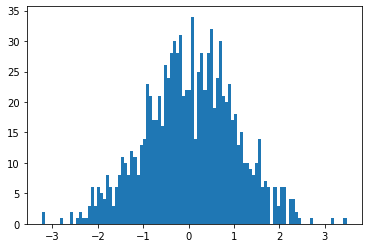

In [3]:
M = MultivariateNormal(Tensor([0.0]), 1.0*ch.ones(1, 1))
samples = M.sample([args.samples])

plt.hist(samples.flatten(), bins=100)
plt.show()

Truncate the Dataset

alpha: 0.84


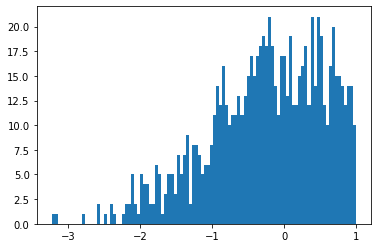

In [4]:
phi = oracle.Right(Tensor([1.0]))
# phi = oracle.Identity()
indices = phi(samples).nonzero()[:,0]
S = samples[indices]
alpha = S.size(0) / samples.size(0)
print("alpha: {}".format(alpha))

plt.hist(S.flatten(), bins=100)
plt.show()

In [5]:
emp_loc = S.mean(0)
print("empirical mean: ", emp_loc)
emp_scale = ch.sqrt(S.var(0))
print("empirical scale: ", emp_scale)

S_norm = (S - emp_loc) / emp_scale
phi_norm = oracle.Right((phi.right - emp_loc) / emp_scale)

empirical mean:  tensor([-0.2501])
empirical scale:  tensor([0.8030])


Run algorithm to Remove Bias from the Dataset

In [6]:
censored = CensoredNormal(phi=phi_norm, 
                          alpha=alpha, 
                          iter_=1, 
                          bs=10, 
                          num_samples=10,
#                           step_lr=100,
#                           step_lr=50,
                          lr=1e-1)
#                           custom_lr_multiplier='adam')
censored.fit(S_norm)

mu: tensor([0.0135])
cov: tensor([[1.0021]])
cov grad: tensor([[-0.0314]])
loc grad: tensor([-1.0675])
mu: tensor([0.1201])
cov: tensor([[0.9989]])
cov grad: tensor([[-0.3492]])
loc grad: tensor([-0.2918])
mu: tensor([0.1442])
cov: tensor([[0.9653]])
cov grad: tensor([[0.4053]])
loc grad: tensor([0.5500])
mu: tensor([0.0948])
cov: tensor([[1.0046]])
cov grad: tensor([[0.0071]])
loc grad: tensor([-0.0047])
mu: tensor([0.0954])
cov: tensor([[1.0053]])
cov grad: tensor([[0.5001]])
loc grad: tensor([0.9882])
mu: tensor([-0.0042])
cov: tensor([[1.0585]])
cov grad: tensor([[0.3840]])
loc grad: tensor([0.4735])
mu: tensor([-0.0566])
cov: tensor([[1.1034]])
cov grad: tensor([[-0.4164]])
loc grad: tensor([-0.3097])
mu: tensor([-0.0215])
cov: tensor([[1.0549]])
cov grad: tensor([[-0.6106]])
loc grad: tensor([-0.6220])
mu: tensor([0.0415])
cov: tensor([[0.9911]])
cov grad: tensor([[0.7855]])
loc grad: tensor([0.4862])
mu: tensor([-0.0073])
cov: tensor([[1.0747]])
cov grad: tensor([[-0.2470]])
loc

In [16]:
(censored.loc * censored.scale.inverse()) * emp_scale + emp_loc

tensor([[-0.0255]])

In [18]:
censored.scale.inverse() * emp_scale.pow(2)

tensor([[1.1876]])

In [26]:
censored.censored_normal.cov_est.mean(1)[None,...]

tensor([[0.7352]], grad_fn=<UnsqueezeBackward0>)

In [28]:
censored.censored_normal.loc_est.mean(1) * censored.censored_normal.cov_est.mean(1)[None,...].inverse() * emp_scale + emp_loc

tensor([[-0.0488]], grad_fn=<AddBackward0>)

In [31]:
censored.censored_normal.cov_est.mean(1)[None,...].inverse() * S.var(0)

tensor([[0.8771]], grad_fn=<MulBackward0>)

In [9]:
(censored.censored_normal.cov_est * emp_scale.pow(2)).mean()

tensor(0.4740, grad_fn=<MeanBackward0>)

In [33]:
store = Store(args.out_dir + '/' + args.exp)

schema = { 
    'kl_div_emp': float, 
    'kl_div_censored': float,
    'kl_div_censored_avg': float,
    'var': int,
}

store.add_table(TABLE_NAME, schema)

for i in range(args.trials): 
    for var in range(1, args.var + 1):
        # create new dataset
        gt_loc, gt_scale = Tensor([0.0]), args.var * ch.ones(1, 1)
        gt_dist = MultivariateNormal(gt_loc, gt_scale)
        samples = gt_dist.sample([args.samples])

        # right truncate at 0
        phi = oracle.Right(Tensor([0.0]))
        indices = phi(samples).nonzero()[:,0]
        S = samples[indices]
        alpha = S.size(0) / samples.size(0)

        emp_dist = MultivariateNormal(S.mean(0), S.var(0) * ch.ones(1, 1))

        S_norm = (S - emp_dist.loc) / ch.sqrt(emp_dist.covariance_matrix) 
        phi_norm = oracle.Right((phi.right - emp_dist.loc) / ch.sqrt(emp_dist.covariance_matrix))


        censored = CensoredNormal(phi=phi_norm, 
                              alpha=alpha, 
                              iter_=1, 
                              bs=10, 
                              num_samples=100,
                              lr=1e-1)
        censored.fit(S_norm)


        loc_ = (censored.loc * censored.scale.inverse() * ch.sqrt(emp_dist.covariance_matrix)) + emp_dist.loc
        scale_ = censored.scale.inverse() * emp_dist.covariance_matrix

        censor_dist = MultivariateNormal(loc_, scale_)

        loc_avg_ = (censored.censored_normal.loc_est.mean() * censored.censored_normal.cov_est.mean(1)[None,...].inverse() * ch.sqrt(emp_dist.covariance_matrix)) + emp_dist.loc
        scale_avg_ = censored.censored_normal.cov_est.mean(1)[None,...].inverse() * emp_dist.covariance_matrix


        censor_dist_avg = MultivariateNormal(loc_avg_, scale_avg_)

        kl_censor = float(kl_divergence(gt_dist, censor_dist))
        kl_censor_avg = float(kl_divergence(gt_dist, censor_dist_avg))
        kl_emp = float(kl_divergence(gt_dist, emp_dist))


        store[TABLE_NAME].update_row({ 
            'kl_div_emp': kl_emp, 
            'kl_div_censored_avg': kl_censor_avg, 
            'kl_div_censored': kl_censor,
            'var': var,
        })
        store[TABLE_NAME].flush_row()
    
store.close()

Logging in: /Users/patroklos/Desktop/exp/sanitycensored/27c73f4d-8d3d-4f1d-bf5d-383bb791a0fd
mu: tensor([0.0086])
cov: tensor([[0.9898]])
cov grad: tensor([[0.0105]])
loc grad: tensor([-0.0445])
mu: tensor([0.0130])
cov: tensor([[0.9909]])
cov grad: tensor([[-0.0053]])
loc grad: tensor([-0.0471])
mu: tensor([0.0177])
cov: tensor([[0.9904]])
cov grad: tensor([[0.9119]])
loc grad: tensor([0.6485])
mu: tensor([-0.0511])
cov: tensor([[1.0887]])
cov grad: tensor([[0.1749]])
loc grad: tensor([-0.5341])
mu: tensor([0.0071])
cov: tensor([[1.1098]])
cov grad: tensor([[-0.1253]])
loc grad: tensor([-0.1438])
mu: tensor([0.0228])
cov: tensor([[1.0946]])
cov grad: tensor([[0.0389]])
loc grad: tensor([-0.6550])
mu: tensor([0.0949])
cov: tensor([[1.0993]])
cov grad: tensor([[0.0500]])
loc grad: tensor([0.1058])
mu: tensor([0.0837])
cov: tensor([[1.1054]])
cov grad: tensor([[-0.2870]])
loc grad: tensor([-0.2855])
mu: tensor([0.1117])
cov: tensor([[1.0714]])
cov grad: tensor([[-0.0017]])
loc grad: tens

loc grad: tensor([0.0928])
mu: tensor([0.6620])
cov: tensor([[1.3628]])
cov grad: tensor([[0.0057]])
loc grad: tensor([0.3969])
mu: tensor([0.6084])
cov: tensor([[1.3639]])
cov grad: tensor([[0.5773]])
loc grad: tensor([0.9483])
mu: tensor([0.5200])
cov: tensor([[1.4804]])
cov grad: tensor([[-0.0312]])
loc grad: tensor([-0.3959])
mu: tensor([0.5760])
cov: tensor([[1.4736]])
cov grad: tensor([[-0.0894]])
loc grad: tensor([-0.4667])
mu: tensor([0.6364])
cov: tensor([[1.4545]])
cov grad: tensor([[-0.0911]])
loc grad: tensor([0.4268])
mu: tensor([0.5668])
cov: tensor([[1.4354]])
cov grad: tensor([[0.2672]])
loc grad: tensor([0.0437])
mu: tensor([0.5829])
cov: tensor([[1.4927]])
cov grad: tensor([[-0.3455]])
loc grad: tensor([0.7548])
mu: tensor([0.4471])
cov: tensor([[1.4195]])
Iteration 1 | Log Likelihood: 0.099
mu: tensor([-0.0040])
cov: tensor([[0.9785]])
cov grad: tensor([[0.3654]])
loc grad: tensor([0.1568])
mu: tensor([-0.0200])
cov: tensor([[1.0147]])
cov grad: tensor([[-0.0199]])
l

mu: tensor([0.0605])
cov: tensor([[0.9884]])
cov grad: tensor([[0.3209]])
loc grad: tensor([-0.5953])
mu: tensor([0.1233])
cov: tensor([[1.0208]])
cov grad: tensor([[0.3111]])
loc grad: tensor([-0.3255])
mu: tensor([0.1616])
cov: tensor([[1.0542]])
cov grad: tensor([[-0.0122]])
loc grad: tensor([0.0081])
mu: tensor([0.1606])
cov: tensor([[1.0529]])
cov grad: tensor([[0.8053]])
loc grad: tensor([0.5786])
mu: tensor([0.1089])
cov: tensor([[1.1504]])
cov grad: tensor([[-0.2436]])
loc grad: tensor([-0.3738])
mu: tensor([0.1478])
cov: tensor([[1.1191]])
cov grad: tensor([[-0.9769]])
loc grad: tensor([-0.9574])
mu: tensor([0.2298])
cov: tensor([[1.0088]])
cov grad: tensor([[0.9255]])
loc grad: tensor([0.4572])
mu: tensor([0.2026])
cov: tensor([[1.1127]])
cov grad: tensor([[0.0620]])
loc grad: tensor([0.6937])
mu: tensor([0.1263])
cov: tensor([[1.1204]])
cov grad: tensor([[-0.4958]])
loc grad: tensor([-1.0060])
mu: tensor([0.2264])
cov: tensor([[1.0614]])
cov grad: tensor([[-0.1852]])
loc gra

cov: tensor([[1.1688]])
cov grad: tensor([[0.1864]])
loc grad: tensor([0.7123])
mu: tensor([-0.0897])
cov: tensor([[1.1948]])
cov grad: tensor([[0.1769]])
loc grad: tensor([-0.1112])
mu: tensor([-0.0780])
cov: tensor([[1.2206]])
cov grad: tensor([[-0.4733]])
loc grad: tensor([-1.0014])
mu: tensor([0.0418])
cov: tensor([[1.1540]])
cov grad: tensor([[0.1910]])
loc grad: tensor([0.0678])
mu: tensor([0.0347])
cov: tensor([[1.1800]])
cov grad: tensor([[-0.2827]])
loc grad: tensor([-0.4309])
mu: tensor([0.0828])
cov: tensor([[1.1419]])
cov grad: tensor([[0.1896]])
loc grad: tensor([-0.8011])
mu: tensor([0.1781])
cov: tensor([[1.1672]])
cov grad: tensor([[0.3714]])
loc grad: tensor([0.2658])
mu: tensor([0.1538])
cov: tensor([[1.2200]])
cov grad: tensor([[-0.0445]])
loc grad: tensor([-0.0258])
mu: tensor([0.1561])
cov: tensor([[1.2134]])
cov grad: tensor([[0.1799]])
loc grad: tensor([-0.0501])
mu: tensor([0.1658])
cov: tensor([[1.2405]])
cov grad: tensor([[0.5063]])
loc grad: tensor([0.1112])


mu: tensor([0.5957])
cov: tensor([[1.5855]])
cov grad: tensor([[-0.0543]])
loc grad: tensor([-0.5284])
mu: tensor([0.6736])
cov: tensor([[1.5719]])
cov grad: tensor([[0.0848]])
loc grad: tensor([0.8068])
mu: tensor([0.5542])
cov: tensor([[1.5932]])
cov grad: tensor([[-0.1589]])
loc grad: tensor([-0.3979])
mu: tensor([0.6023])
cov: tensor([[1.5538]])
cov grad: tensor([[0.4106]])
loc grad: tensor([0.2174])
mu: tensor([0.6073])
cov: tensor([[1.6597]])
cov grad: tensor([[-0.0290]])
loc grad: tensor([-0.1994])
mu: tensor([0.6373])
cov: tensor([[1.6518]])
cov grad: tensor([[0.6951]])
loc grad: tensor([0.1227])
mu: tensor([0.6971])
cov: tensor([[1.8660]])
cov grad: tensor([[0.1489]])
loc grad: tensor([0.4835])
mu: tensor([0.6242])
cov: tensor([[1.9194]])
cov grad: tensor([[-0.0499]])
loc grad: tensor([0.0738])
mu: tensor([0.6043])
cov: tensor([[1.9012]])
cov grad: tensor([[-0.0036]])
loc grad: tensor([-0.5031])
mu: tensor([0.6994])
cov: tensor([[1.8999]])
cov grad: tensor([[0.2509]])
loc grad

mu: tensor([-0.0154])
cov: tensor([[1.0305]])
cov grad: tensor([[0.0725]])
loc grad: tensor([-0.1642])
mu: tensor([0.0015])
cov: tensor([[1.0383]])
cov grad: tensor([[0.7135]])
loc grad: tensor([0.0392])
mu: tensor([-0.0028])
cov: tensor([[1.1213]])
cov grad: tensor([[-0.1462]])
loc grad: tensor([-0.7747])
mu: tensor([0.0828])
cov: tensor([[1.1033]])
cov grad: tensor([[-0.0876]])
loc grad: tensor([-0.3780])
mu: tensor([0.1233])
cov: tensor([[1.0927]])
cov grad: tensor([[-0.1444]])
loc grad: tensor([-0.4004])
mu: tensor([0.1644])
cov: tensor([[1.0757]])
cov grad: tensor([[0.4164]])
loc grad: tensor([0.0416])
mu: tensor([0.1674])
cov: tensor([[1.1262]])
cov grad: tensor([[-0.2476]])
loc grad: tensor([-0.4073])
mu: tensor([0.2075])
cov: tensor([[1.0956]])
cov grad: tensor([[0.4589]])
loc grad: tensor([0.2392])
mu: tensor([0.1909])
cov: tensor([[1.1536]])
cov grad: tensor([[0.0598]])
loc grad: tensor([0.0047])
mu: tensor([0.1917])
cov: tensor([[1.1616]])
cov grad: tensor([[0.4815]])
loc gr

loc grad: tensor([-0.0477])
mu: tensor([0.2352])
cov: tensor([[1.2365]])
cov grad: tensor([[-0.3536]])
loc grad: tensor([-0.0997])
mu: tensor([0.2371])
cov: tensor([[1.1847]])
cov grad: tensor([[-0.1238]])
loc grad: tensor([0.3087])
mu: tensor([0.1977])
cov: tensor([[1.1676]])
cov grad: tensor([[-0.1920]])
loc grad: tensor([-0.3470])
mu: tensor([0.2329])
cov: tensor([[1.1419]])
cov grad: tensor([[0.0410]])
loc grad: tensor([-0.0945])
mu: tensor([0.2449])
cov: tensor([[1.1473]])
cov grad: tensor([[0.2001]])
loc grad: tensor([0.4963])
mu: tensor([0.1924])
cov: tensor([[1.1743]])
cov grad: tensor([[0.2115]])
loc grad: tensor([-0.4127])
mu: tensor([0.2470])
cov: tensor([[1.2042]])
cov grad: tensor([[0.9027]])
loc grad: tensor([0.5494])
mu: tensor([0.2028])
cov: tensor([[1.3510]])
cov grad: tensor([[0.0292]])
loc grad: tensor([-0.4488])
mu: tensor([0.2645])
cov: tensor([[1.3564]])
cov grad: tensor([[0.1598]])
loc grad: tensor([0.1974])
mu: tensor([0.2430])
cov: tensor([[1.3864]])
cov grad: 

cov: tensor([[1.2220]])
cov grad: tensor([[0.3443]])
loc grad: tensor([0.1647])
mu: tensor([0.0081])
cov: tensor([[1.2757]])
cov grad: tensor([[0.1795]])
loc grad: tensor([0.5554])
mu: tensor([-0.0642])
cov: tensor([[1.3056]])
cov grad: tensor([[0.2056]])
loc grad: tensor([0.4115])
mu: tensor([-0.1212])
cov: tensor([[1.3416]])
cov grad: tensor([[-0.0883]])
loc grad: tensor([0.0210])
mu: tensor([-0.1225])
cov: tensor([[1.3259]])
cov grad: tensor([[0.4667]])
loc grad: tensor([0.4069])
mu: tensor([-0.1881])
cov: tensor([[1.4133]])
cov grad: tensor([[0.1161]])
loc grad: tensor([-0.5179])
mu: tensor([-0.1169])
cov: tensor([[1.4369]])
cov grad: tensor([[-0.2393]])
loc grad: tensor([-0.9741])
mu: tensor([0.0223])
cov: tensor([[1.3891]])
cov grad: tensor([[-0.4478]])
loc grad: tensor([-0.8279])
mu: tensor([0.1293])
cov: tensor([[1.3078]])
cov grad: tensor([[-0.7354]])
loc grad: tensor([-0.4913])
mu: tensor([0.1766])
cov: tensor([[1.1931]])
cov grad: tensor([[0.0408]])
loc grad: tensor([0.2850]

cov grad: tensor([[-0.2239]])
loc grad: tensor([-0.0613])
mu: tensor([0.3634])
cov: tensor([[1.4115]])
cov grad: tensor([[-0.2810]])
loc grad: tensor([-0.1450])
mu: tensor([0.3692])
cov: tensor([[1.3577]])
cov grad: tensor([[-0.3955]])
loc grad: tensor([-0.2409])
mu: tensor([0.3814])
cov: tensor([[1.2885]])
cov grad: tensor([[-0.1033]])
loc grad: tensor([-0.0556])
mu: tensor([0.3835])
cov: tensor([[1.2716]])
cov grad: tensor([[0.8006]])
loc grad: tensor([0.3607])
mu: tensor([0.3759])
cov: tensor([[1.4157]])
cov grad: tensor([[0.5856]])
loc grad: tensor([0.9552])
mu: tensor([0.2624])
cov: tensor([[1.5437]])
cov grad: tensor([[-0.0937]])
loc grad: tensor([0.0103])
mu: tensor([0.2571])
cov: tensor([[1.5216]])
cov grad: tensor([[-0.1469]])
loc grad: tensor([-1.0941])
mu: tensor([0.4143])
cov: tensor([[1.4884]])
cov grad: tensor([[-0.2045]])
loc grad: tensor([0.0673])
mu: tensor([0.3924])
cov: tensor([[1.4444]])
cov grad: tensor([[-0.1707]])
loc grad: tensor([-0.4577])
mu: tensor([0.4474])


cov grad: tensor([[0.1909]])
loc grad: tensor([-0.3082])
mu: tensor([0.5053])
cov: tensor([[1.6344]])
cov grad: tensor([[0.0982]])
loc grad: tensor([0.0281])
mu: tensor([0.5088])
cov: tensor([[1.6611]])
Iteration 1 | Log Likelihood: 0.08
mu: tensor([0.0208])
cov: tensor([[0.9982]])
cov grad: tensor([[-0.0281]])
loc grad: tensor([-1.1247])
mu: tensor([0.1327])
cov: tensor([[0.9954]])
cov grad: tensor([[0.3407]])
loc grad: tensor([0.1617])
mu: tensor([0.1207])
cov: tensor([[1.0304]])
cov grad: tensor([[0.2031]])
loc grad: tensor([-0.2287])
mu: tensor([0.1473])
cov: tensor([[1.0524]])
cov grad: tensor([[-0.1664]])
loc grad: tensor([-0.3588])
mu: tensor([0.1819])
cov: tensor([[1.0343]])
cov grad: tensor([[0.0507]])
loc grad: tensor([0.5653])
mu: tensor([0.1241])
cov: tensor([[1.0397]])
cov grad: tensor([[0.4315]])
loc grad: tensor([-0.1947])
mu: tensor([0.1511])
cov: tensor([[1.0886]])
cov grad: tensor([[-0.3664]])
loc grad: tensor([-0.0227])
mu: tensor([0.1477])
cov: tensor([[1.0468]])
co

cov grad: tensor([[0.1727]])
loc grad: tensor([-0.1114])
mu: tensor([-0.0322])
cov: tensor([[1.0345]])
cov grad: tensor([[-0.2207]])
loc grad: tensor([-0.6427])
mu: tensor([0.0335])
cov: tensor([[1.0114]])
cov grad: tensor([[-0.1888]])
loc grad: tensor([-0.1126])
mu: tensor([0.0441])
cov: tensor([[0.9924]])
cov grad: tensor([[0.0580]])
loc grad: tensor([-0.5663])
mu: tensor([0.1009])
cov: tensor([[0.9982]])
cov grad: tensor([[-0.2536]])
loc grad: tensor([-1.2012])
mu: tensor([0.2153])
cov: tensor([[0.9735]])
cov grad: tensor([[0.3771]])
loc grad: tensor([-0.4394])
mu: tensor([0.2679])
cov: tensor([[1.0106]])
cov grad: tensor([[0.4530]])
loc grad: tensor([0.4375])
mu: tensor([0.2344])
cov: tensor([[1.0591]])
cov grad: tensor([[-0.0665]])
loc grad: tensor([0.4272])
mu: tensor([0.1879])
cov: tensor([[1.0517]])
cov grad: tensor([[0.2601]])
loc grad: tensor([-0.4434])
mu: tensor([0.2411])
cov: tensor([[1.0813]])
cov grad: tensor([[0.1135]])
loc grad: tensor([0.5655])
mu: tensor([0.1822])
co

cov grad: tensor([[-0.5744]])
loc grad: tensor([-0.3364])
mu: tensor([0.4314])
cov: tensor([[1.1976]])
cov grad: tensor([[0.1645]])
loc grad: tensor([0.2563])
mu: tensor([0.4088])
cov: tensor([[1.2217]])
cov grad: tensor([[0.1669]])
loc grad: tensor([-0.2443])
mu: tensor([0.4478])
cov: tensor([[1.2471]])
cov grad: tensor([[0.9749]])
loc grad: tensor([0.6752])
mu: tensor([0.4139])
cov: tensor([[1.4198]])
cov grad: tensor([[-0.1889]])
loc grad: tensor([-0.7127])
mu: tensor([0.5016])
cov: tensor([[1.3827]])
cov grad: tensor([[0.2149]])
loc grad: tensor([0.0811])
mu: tensor([0.5054])
cov: tensor([[1.4250]])
cov grad: tensor([[0.5570]])
loc grad: tensor([0.0547])
mu: tensor([0.5406])
cov: tensor([[1.5479]])
cov grad: tensor([[-0.4632]])
loc grad: tensor([-0.4129])
mu: tensor([0.5640])
cov: tensor([[1.4443]])
cov grad: tensor([[0.1203]])
loc grad: tensor([0.1890])
mu: tensor([0.5462])
cov: tensor([[1.4699]])
cov grad: tensor([[0.2056]])
loc grad: tensor([0.3327])
mu: tensor([0.5128])
cov: te

loc grad: tensor([0.1029])
mu: tensor([0.2464])
cov: tensor([[1.4127]])
cov grad: tensor([[0.0528]])
loc grad: tensor([0.4851])
mu: tensor([0.1793])
cov: tensor([[1.4233]])
cov grad: tensor([[-0.0360]])
loc grad: tensor([0.1550])
mu: tensor([0.1564])
cov: tensor([[1.4160]])
cov grad: tensor([[-0.6725]])
loc grad: tensor([-1.0161])
mu: tensor([0.2742])
cov: tensor([[1.2929]])
cov grad: tensor([[-0.3950]])
loc grad: tensor([-0.6202])
mu: tensor([0.3371])
cov: tensor([[1.2301]])
cov grad: tensor([[0.2154]])
loc grad: tensor([-0.0364])
mu: tensor([0.3509])
cov: tensor([[1.2636]])
cov grad: tensor([[0.8877]])
loc grad: tensor([0.6940])
mu: tensor([0.2965])
cov: tensor([[1.4232]])
cov grad: tensor([[-0.2461]])
loc grad: tensor([-0.4895])
mu: tensor([0.3538])
cov: tensor([[1.3750]])
cov grad: tensor([[0.2759]])
loc grad: tensor([0.0986])
mu: tensor([0.3536])
cov: tensor([[1.4293]])
cov grad: tensor([[0.3853]])
loc grad: tensor([0.2947])
mu: tensor([0.3296])
cov: tensor([[1.5126]])
cov grad: t

mu: tensor([0.0170])
cov: tensor([[1.0051]])
cov grad: tensor([[-0.1111]])
loc grad: tensor([-0.3011])
mu: tensor([0.0468])
cov: tensor([[0.9940]])
cov grad: tensor([[-0.3676]])
loc grad: tensor([-1.0552])
mu: tensor([0.1463])
cov: tensor([[0.9589]])
cov grad: tensor([[-0.3864]])
loc grad: tensor([-0.4046])
mu: tensor([0.1785])
cov: tensor([[0.9247]])
cov grad: tensor([[0.0053]])
loc grad: tensor([0.1851])
mu: tensor([0.1615])
cov: tensor([[0.9251]])
cov grad: tensor([[0.4558]])
loc grad: tensor([-0.1141])
mu: tensor([0.1796])
cov: tensor([[0.9659]])
cov grad: tensor([[0.4719]])
loc grad: tensor([-0.0335])
mu: tensor([0.1916])
cov: tensor([[1.0120]])
cov grad: tensor([[-0.2220]])
loc grad: tensor([-0.5177])
mu: tensor([0.2386])
cov: tensor([[0.9897]])
cov grad: tensor([[0.0250]])
loc grad: tensor([-0.3210])
mu: tensor([0.2710])
cov: tensor([[0.9922]])
cov grad: tensor([[0.0952]])
loc grad: tensor([0.0692])
mu: tensor([0.2667])
cov: tensor([[1.0017]])
cov grad: tensor([[0.3395]])
loc gr

mu: tensor([0.0524])
cov: tensor([[1.1838]])
cov grad: tensor([[-0.3273]])
loc grad: tensor([-0.2920])
mu: tensor([0.0837])
cov: tensor([[1.1396]])
cov grad: tensor([[-0.0824]])
loc grad: tensor([-0.7557])
mu: tensor([0.1683])
cov: tensor([[1.1290]])
cov grad: tensor([[0.6164]])
loc grad: tensor([-0.0666])
mu: tensor([0.1889])
cov: tensor([[1.2135]])
cov grad: tensor([[0.2727]])
loc grad: tensor([0.0527])
mu: tensor([0.1888])
cov: tensor([[1.2550]])
cov grad: tensor([[0.3028]])
loc grad: tensor([0.0200])
mu: tensor([0.1936])
cov: tensor([[1.3046]])
cov grad: tensor([[-0.0951]])
loc grad: tensor([-0.4128])
mu: tensor([0.2445])
cov: tensor([[1.2886]])
cov grad: tensor([[0.2770]])
loc grad: tensor([-0.0349])
mu: tensor([0.2582])
cov: tensor([[1.3363]])
cov grad: tensor([[-0.0842]])
loc grad: tensor([0.0288])
mu: tensor([0.2515])
cov: tensor([[1.3214]])
cov grad: tensor([[0.1343]])
loc grad: tensor([-0.0547])
mu: tensor([0.2634])
cov: tensor([[1.3453]])
cov grad: tensor([[0.2982]])
loc gra

loc grad: tensor([0.4371])
mu: tensor([0.6719])
cov: tensor([[1.4359]])
cov grad: tensor([[0.4665]])
loc grad: tensor([0.2133])
mu: tensor([0.6873])
cov: tensor([[1.5389]])
Iteration 1 | Log Likelihood: 0.076
mu: tensor([0.0057])
cov: tensor([[1.0027]])
cov grad: tensor([[0.1918]])
loc grad: tensor([-0.4540])
mu: tensor([0.0522])
cov: tensor([[1.0223]])
cov grad: tensor([[-0.2818]])
loc grad: tensor([-0.7931])
mu: tensor([0.1296])
cov: tensor([[0.9937]])
cov grad: tensor([[0.0752]])
loc grad: tensor([0.5991])
mu: tensor([0.0706])
cov: tensor([[1.0012]])
cov grad: tensor([[-0.1618]])
loc grad: tensor([0.1219])
mu: tensor([0.0575])
cov: tensor([[0.9852]])
cov grad: tensor([[0.3247]])
loc grad: tensor([0.1929])
mu: tensor([0.0397])
cov: tensor([[1.0178]])
cov grad: tensor([[0.0992]])
loc grad: tensor([-0.4055])
mu: tensor([0.0818])
cov: tensor([[1.0282]])
cov grad: tensor([[-0.4234]])
loc grad: tensor([-0.8548])
mu: tensor([0.1626])
cov: tensor([[0.9853]])
cov grad: tensor([[0.1607]])
loc

loc grad: tensor([0.0442])
mu: tensor([0.7234])
cov: tensor([[1.5549]])
cov grad: tensor([[0.3406]])
loc grad: tensor([0.2915])
mu: tensor([0.7160])
cov: tensor([[1.6419]])
cov grad: tensor([[0.4484]])
loc grad: tensor([-0.0238])
mu: tensor([0.7772])
cov: tensor([[1.7724]])
cov grad: tensor([[0.1410]])
loc grad: tensor([-0.0563])
mu: tensor([0.8073])
cov: tensor([[1.8178]])
cov grad: tensor([[0.0614]])
loc grad: tensor([-0.4937])
mu: tensor([0.9072])
cov: tensor([[1.8383]])
cov grad: tensor([[-0.3367]])
loc grad: tensor([-0.1174])
mu: tensor([0.8746])
cov: tensor([[1.7311]])
cov grad: tensor([[-0.0581]])
loc grad: tensor([-0.4670])
mu: tensor([0.9460])
cov: tensor([[1.7139]])
cov grad: tensor([[-0.5431]])
loc grad: tensor([-0.4672])
mu: tensor([0.9387])
cov: tensor([[1.5680]])
Iteration 1 | Log Likelihood: 0.176
mu: tensor([-0.0062])
cov: tensor([[1.0099]])
cov grad: tensor([[-0.5359]])
loc grad: tensor([-0.6615])
mu: tensor([0.0575])
cov: tensor([[0.9581]])
cov grad: tensor([[-0.0208]

mu: tensor([0.0007])
cov: tensor([[0.9869]])
cov grad: tensor([[0.1598]])
loc grad: tensor([0.0023])
mu: tensor([0.0004])
cov: tensor([[1.0027]])
cov grad: tensor([[0.7421]])
loc grad: tensor([0.4925])
mu: tensor([-0.0529])
cov: tensor([[1.0833]])
cov grad: tensor([[-0.0144]])
loc grad: tensor([-0.1455])
mu: tensor([-0.0371])
cov: tensor([[1.0816]])
cov grad: tensor([[-0.1096]])
loc grad: tensor([-0.6115])
mu: tensor([0.0287])
cov: tensor([[1.0689]])
cov grad: tensor([[0.9052]])
loc grad: tensor([1.2696])
mu: tensor([-0.1184])
cov: tensor([[1.1834]])
cov grad: tensor([[0.6136]])
loc grad: tensor([-0.4985])
mu: tensor([-0.0641])
cov: tensor([[1.2761]])
cov grad: tensor([[0.2815]])
loc grad: tensor([-0.7613])
mu: tensor([0.0343])
cov: tensor([[1.3237]])
cov grad: tensor([[0.3489]])
loc grad: tensor([-0.1184])
mu: tensor([0.0524])
cov: tensor([[1.3877]])
cov grad: tensor([[-0.1778]])
loc grad: tensor([-0.4503])
mu: tensor([0.1121])
cov: tensor([[1.3543]])
cov grad: tensor([[-0.0973]])
loc

cov grad: tensor([[0.0488]])
loc grad: tensor([0.5219])
mu: tensor([0.4289])
cov: tensor([[1.3311]])
cov grad: tensor([[-0.1409]])
loc grad: tensor([-0.2541])
mu: tensor([0.4542])
cov: tensor([[1.3066]])
cov grad: tensor([[0.1637]])
loc grad: tensor([0.6950])
mu: tensor([0.3714])
cov: tensor([[1.3351]])
cov grad: tensor([[0.1572]])
loc grad: tensor([-0.4362])
mu: tensor([0.4388])
cov: tensor([[1.3637]])
cov grad: tensor([[-0.1397]])
loc grad: tensor([0.2280])
mu: tensor([0.4001])
cov: tensor([[1.3382]])
cov grad: tensor([[0.6610]])
loc grad: tensor([0.6197])
mu: tensor([0.3480])
cov: tensor([[1.4681]])
cov grad: tensor([[-0.1040]])
loc grad: tensor([0.0968])
mu: tensor([0.3287])
cov: tensor([[1.4460]])
cov grad: tensor([[0.0928]])
loc grad: tensor([-0.5318])
mu: tensor([0.4112])
cov: tensor([[1.4657]])
cov grad: tensor([[0.2621]])
loc grad: tensor([-0.1226])
mu: tensor([0.4463])
cov: tensor([[1.5242]])
cov grad: tensor([[0.4594]])
loc grad: tensor([0.5239])
mu: tensor([0.3940])
cov: te

loc grad: tensor([0.0326])
mu: tensor([0.6418])
cov: tensor([[1.5354]])
cov grad: tensor([[-0.4795]])
loc grad: tensor([-0.0950])
mu: tensor([0.6113])
cov: tensor([[1.4301]])
cov grad: tensor([[-0.4271]])
loc grad: tensor([-0.3340])
mu: tensor([0.6212])
cov: tensor([[1.3478]])
cov grad: tensor([[-0.0242]])
loc grad: tensor([-0.1334])
mu: tensor([0.6371])
cov: tensor([[1.3434]])
cov grad: tensor([[0.3888]])
loc grad: tensor([0.2599])
mu: tensor([0.6353])
cov: tensor([[1.4174]])
cov grad: tensor([[0.4064]])
loc grad: tensor([0.4108])
mu: tensor([0.6124])
cov: tensor([[1.5041]])
cov grad: tensor([[0.3574]])
loc grad: tensor([-0.4205])
mu: tensor([0.7140])
cov: tensor([[1.5895]])
cov grad: tensor([[0.2788]])
loc grad: tensor([0.1121])
mu: tensor([0.7285])
cov: tensor([[1.6632]])
cov grad: tensor([[0.3428]])
loc grad: tensor([0.3823])
mu: tensor([0.7051])
cov: tensor([[1.7638]])
cov grad: tensor([[0.5867]])
loc grad: tensor([0.4270])
mu: tensor([0.7025])
cov: tensor([[1.9674]])
cov grad: te

mu: tensor([0.3414])
cov: tensor([[1.1036]])
cov grad: tensor([[-0.3162]])
loc grad: tensor([-0.1819])
mu: tensor([0.3493])
cov: tensor([[1.0664]])
cov grad: tensor([[0.5788]])
loc grad: tensor([0.6607])
mu: tensor([0.2972])
cov: tensor([[1.1366]])
cov grad: tensor([[-0.0004]])
loc grad: tensor([-0.1317])
mu: tensor([0.3121])
cov: tensor([[1.1365]])
cov grad: tensor([[0.6688]])
loc grad: tensor([0.4593])
mu: tensor([0.2813])
cov: tensor([[1.2300]])
cov grad: tensor([[0.4065]])
loc grad: tensor([-0.2824])
mu: tensor([0.3327])
cov: tensor([[1.2948]])
cov grad: tensor([[0.7912]])
loc grad: tensor([1.0282])
mu: tensor([0.2223])
cov: tensor([[1.4425]])
cov grad: tensor([[0.3824]])
loc grad: tensor([-0.0871])
mu: tensor([0.2486])
cov: tensor([[1.5268]])
cov grad: tensor([[-0.0252]])
loc grad: tensor([0.0609])
mu: tensor([0.2384])
cov: tensor([[1.5209]])
cov grad: tensor([[-0.0694]])
loc grad: tensor([-0.3466])
mu: tensor([0.2881])
cov: tensor([[1.5050]])
cov grad: tensor([[-0.0413]])
loc gra

cov grad: tensor([[-0.3554]])
loc grad: tensor([-0.6267])
mu: tensor([0.6574])
cov: tensor([[1.4975]])
cov grad: tensor([[1.5393]])
loc grad: tensor([1.3611])
mu: tensor([0.5895])
cov: tensor([[1.9461]])
Iteration 1 | Log Likelihood: 0.163
mu: tensor([-0.0052])
cov: tensor([[1.0080]])
cov grad: tensor([[0.6902]])
loc grad: tensor([0.3685])
mu: tensor([-0.0456])
cov: tensor([[1.0834]])
cov grad: tensor([[-0.0974]])
loc grad: tensor([-0.1533])
mu: tensor([-0.0287])
cov: tensor([[1.0721]])
cov grad: tensor([[-0.1024]])
loc grad: tensor([-0.4334])
mu: tensor([0.0176])
cov: tensor([[1.0605]])
cov grad: tensor([[0.3478]])
loc grad: tensor([0.2385])
mu: tensor([-0.0080])
cov: tensor([[1.1011]])
cov grad: tensor([[-0.0611]])
loc grad: tensor([-0.4843])
mu: tensor([0.0451])
cov: tensor([[1.0937]])
cov grad: tensor([[0.5474]])
loc grad: tensor([0.3027])
mu: tensor([0.0127])
cov: tensor([[1.1634]])
cov grad: tensor([[-0.1208]])
loc grad: tensor([-0.9572])
mu: tensor([0.1223])
cov: tensor([[1.1473

cov grad: tensor([[-0.1144]])
loc grad: tensor([-0.0833])
mu: tensor([0.7438])
cov: tensor([[1.5789]])
cov grad: tensor([[-0.1598]])
loc grad: tensor([0.2396])
mu: tensor([0.6886])
cov: tensor([[1.5400]])
cov grad: tensor([[0.0906]])
loc grad: tensor([-0.1874])
mu: tensor([0.7276])
cov: tensor([[1.5618]])
cov grad: tensor([[0.0400]])
loc grad: tensor([0.0472])
mu: tensor([0.7247])
cov: tensor([[1.5716]])
cov grad: tensor([[-0.0519]])
loc grad: tensor([0.0035])
mu: tensor([0.7183])
cov: tensor([[1.5589]])
cov grad: tensor([[0.4951]])
loc grad: tensor([0.5969])
mu: tensor([0.6776])
cov: tensor([[1.6893]])
cov grad: tensor([[0.7225]])
loc grad: tensor([1.1590])
mu: tensor([0.5488])
cov: tensor([[1.9241]])
cov grad: tensor([[0.1914]])
loc grad: tensor([0.5141])
mu: tensor([0.4670])
cov: tensor([[1.9977]])
cov grad: tensor([[0.0361]])
loc grad: tensor([-0.4727])
mu: tensor([0.5655])
cov: tensor([[2.0122]])
cov grad: tensor([[0.0790]])
loc grad: tensor([0.1670])
mu: tensor([0.5405])
cov: ten

cov: tensor([[1.3977]])
cov grad: tensor([[-0.1343]])
loc grad: tensor([-0.2508])
mu: tensor([0.3558])
cov: tensor([[1.3720]])
cov grad: tensor([[0.0090]])
loc grad: tensor([-0.0772])
mu: tensor([0.3668])
cov: tensor([[1.3737]])
cov grad: tensor([[-0.2761]])
loc grad: tensor([0.3727])
mu: tensor([0.3041])
cov: tensor([[1.3235]])
cov grad: tensor([[0.1831]])
loc grad: tensor([-0.3892])
mu: tensor([0.3644])
cov: tensor([[1.3564]])
cov grad: tensor([[-0.2486]])
loc grad: tensor([-0.8205])
mu: tensor([0.4602])
cov: tensor([[1.3121]])
cov grad: tensor([[0.0779]])
loc grad: tensor([0.3358])
mu: tensor([0.4204])
cov: tensor([[1.3257]])
cov grad: tensor([[0.4754]])
loc grad: tensor([0.3492])
mu: tensor([0.3993])
cov: tensor([[1.4148]])
cov grad: tensor([[-0.2625]])
loc grad: tensor([-0.6984])
mu: tensor([0.4803])
cov: tensor([[1.3642]])
cov grad: tensor([[0.9127]])
loc grad: tensor([0.5012])
mu: tensor([0.4705])
cov: tensor([[1.5582]])
cov grad: tensor([[0.2278]])
loc grad: tensor([-0.1831])
m

cov: tensor([[1.6394]])
cov grad: tensor([[-0.3151]])
loc grad: tensor([-0.7860])
mu: tensor([0.3432])
cov: tensor([[1.5588]])
cov grad: tensor([[0.2726]])
loc grad: tensor([0.1046])
mu: tensor([0.3414])
cov: tensor([[1.6280]])
cov grad: tensor([[0.4152]])
loc grad: tensor([0.9027])
mu: tensor([0.2085])
cov: tensor([[1.7460]])
cov grad: tensor([[0.8770]])
loc grad: tensor([0.5184])
mu: tensor([0.1394])
cov: tensor([[2.0617]])
cov grad: tensor([[-0.0752]])
loc grad: tensor([-0.2377])
mu: tensor([0.1855])
cov: tensor([[2.0303]])
cov grad: tensor([[-0.6128]])
loc grad: tensor([-0.5619])
mu: tensor([0.2664])
cov: tensor([[1.8056]])
cov grad: tensor([[-1.1773]])
loc grad: tensor([-0.5986])
mu: tensor([0.3089])
cov: tensor([[1.4891]])
cov grad: tensor([[-0.1110]])
loc grad: tensor([-0.3467])
mu: tensor([0.3546])
cov: tensor([[1.4649]])
cov grad: tensor([[0.2904]])
loc grad: tensor([0.6937])
mu: tensor([0.2642])
cov: tensor([[1.5299]])
cov grad: tensor([[-0.1430]])
loc grad: tensor([-0.1265])

mu: tensor([0.0247])
cov: tensor([[1.0569]])
cov grad: tensor([[0.2010]])
loc grad: tensor([0.0179])
mu: tensor([0.0233])
cov: tensor([[1.0798]])
cov grad: tensor([[0.0134]])
loc grad: tensor([-0.4673])
mu: tensor([0.0739])
cov: tensor([[1.0814]])
cov grad: tensor([[-0.1879]])
loc grad: tensor([-0.7619])
mu: tensor([0.1531])
cov: tensor([[1.0598]])
cov grad: tensor([[0.7806]])
loc grad: tensor([0.5567])
mu: tensor([0.1026])
cov: tensor([[1.1554]])
cov grad: tensor([[0.3653]])
loc grad: tensor([-0.1077])
mu: tensor([0.1201])
cov: tensor([[1.2064]])
cov grad: tensor([[0.4956]])
loc grad: tensor([0.5371])
mu: tensor([0.0589])
cov: tensor([[1.2831]])
cov grad: tensor([[0.2200]])
loc grad: tensor([-0.2203])
mu: tensor([0.0897])
cov: tensor([[1.3203]])
cov grad: tensor([[0.0307]])
loc grad: tensor([-0.1191])
mu: tensor([0.1058])
cov: tensor([[1.3257]])
cov grad: tensor([[0.0670]])
loc grad: tensor([0.6695])
mu: tensor([0.0172])
cov: tensor([[1.3376]])
cov grad: tensor([[0.1935]])
loc grad: t

mu: tensor([0.7317])
cov: tensor([[1.9856]])
cov grad: tensor([[0.0246]])
loc grad: tensor([0.1642])
mu: tensor([0.7025])
cov: tensor([[1.9954]])
cov grad: tensor([[0.5670]])
loc grad: tensor([0.5195])
mu: tensor([0.6752])
cov: tensor([[2.2499]])
cov grad: tensor([[0.2627]])
loc grad: tensor([0.3239])
mu: tensor([0.6402])
cov: tensor([[2.3913]])
cov grad: tensor([[-0.7870]])
loc grad: tensor([-1.5049])
mu: tensor([0.8417])
cov: tensor([[2.0125]])
cov grad: tensor([[0.0902]])
loc grad: tensor([0.1585])
mu: tensor([0.8247])
cov: tensor([[2.0498]])
cov grad: tensor([[0.0391]])
loc grad: tensor([0.0939])
mu: tensor([0.8120])
cov: tensor([[2.0663]])
cov grad: tensor([[-0.2876]])
loc grad: tensor([-0.0519])
mu: tensor([0.7766])
cov: tensor([[1.9504]])
Iteration 1 | Log Likelihood: 0.262
mu: tensor([-0.0043])
cov: tensor([[1.0032]])
cov grad: tensor([[0.0591]])
loc grad: tensor([-0.4293])
mu: tensor([0.0390])
cov: tensor([[1.0091]])
cov grad: tensor([[0.2170]])
loc grad: tensor([0.7811])
mu: 

loc grad: tensor([-0.0883])
mu: tensor([0.2342])
cov: tensor([[1.6360]])
cov grad: tensor([[-0.6268]])
loc grad: tensor([-1.1654])
mu: tensor([0.3853])
cov: tensor([[1.4838]])
cov grad: tensor([[-0.0739]])
loc grad: tensor([-0.3534])
mu: tensor([0.4330])
cov: tensor([[1.4678]])
cov grad: tensor([[-0.6126]])
loc grad: tensor([-0.9519])
mu: tensor([0.5255])
cov: tensor([[1.3467]])
cov grad: tensor([[0.8342]])
loc grad: tensor([0.2604])
mu: tensor([0.5525])
cov: tensor([[1.5171]])
cov grad: tensor([[0.1559]])
loc grad: tensor([0.4246])
mu: tensor([0.4999])
cov: tensor([[1.5538]])
cov grad: tensor([[0.0919]])
loc grad: tensor([0.2690])
mu: tensor([0.4647])
cov: tensor([[1.5763]])
cov grad: tensor([[-0.0804]])
loc grad: tensor([-0.2601])
mu: tensor([0.4994])
cov: tensor([[1.5566]])
cov grad: tensor([[-0.0405]])
loc grad: tensor([-0.1829])
mu: tensor([0.5245])
cov: tensor([[1.5469]])
cov grad: tensor([[-0.2087]])
loc grad: tensor([-0.2947])
mu: tensor([0.5523])
cov: tensor([[1.4985]])
cov gr

cov grad: tensor([[0.7049]])
loc grad: tensor([0.4197])
mu: tensor([-0.0312])
cov: tensor([[1.1687]])
cov grad: tensor([[-0.0567]])
loc grad: tensor([-0.8496])
mu: tensor([0.0677])
cov: tensor([[1.1610]])
cov grad: tensor([[-0.6965]])
loc grad: tensor([-1.0396])
mu: tensor([0.1743])
cov: tensor([[1.0742]])
cov grad: tensor([[-0.1724]])
loc grad: tensor([0.7790])
mu: tensor([0.0890])
cov: tensor([[1.0546]])
cov grad: tensor([[0.0445]])
loc grad: tensor([-0.0977])
mu: tensor([0.0997])
cov: tensor([[1.0596]])
cov grad: tensor([[0.0869]])
loc grad: tensor([-0.1863])
mu: tensor([0.1206])
cov: tensor([[1.0695]])
cov grad: tensor([[-0.0727]])
loc grad: tensor([-0.5618])
mu: tensor([0.1793])
cov: tensor([[1.0612]])
cov grad: tensor([[0.0952]])
loc grad: tensor([0.5137])
mu: tensor([0.1260])
cov: tensor([[1.0720]])
cov grad: tensor([[0.1346]])
loc grad: tensor([0.0880])
mu: tensor([0.1183])
cov: tensor([[1.0877]])
cov grad: tensor([[0.1001]])
loc grad: tensor([0.3137])
mu: tensor([0.0851])
cov:

cov: tensor([[1.5737]])
cov grad: tensor([[-0.5552]])
loc grad: tensor([-0.6702])
mu: tensor([0.4246])
cov: tensor([[1.4472]])
cov grad: tensor([[0.2592]])
loc grad: tensor([-0.2470])
mu: tensor([0.4783])
cov: tensor([[1.5036]])
cov grad: tensor([[0.1758]])
loc grad: tensor([0.6103])
mu: tensor([0.3970])
cov: tensor([[1.5445]])
cov grad: tensor([[-0.4653]])
loc grad: tensor([-0.9254])
mu: tensor([0.5037])
cov: tensor([[1.4409]])
cov grad: tensor([[-0.2137]])
loc grad: tensor([-0.1584])
mu: tensor([0.5108])
cov: tensor([[1.3979]])
Iteration 1 | Log Likelihood: 0.088
mu: tensor([-0.0106])
cov: tensor([[1.0000]])
cov grad: tensor([[-0.1686]])
loc grad: tensor([-0.5922])
mu: tensor([0.0478])
cov: tensor([[0.9834]])
cov grad: tensor([[0.2639]])
loc grad: tensor([0.4451])
mu: tensor([0.0042])
cov: tensor([[1.0096]])
cov grad: tensor([[-0.2729]])
loc grad: tensor([-0.6085])
mu: tensor([0.0638])
cov: tensor([[0.9826]])
cov grad: tensor([[0.4034]])
loc grad: tensor([-0.0982])
mu: tensor([0.0765

cov grad: tensor([[0.2945]])
loc grad: tensor([-0.3160])
mu: tensor([0.7972])
cov: tensor([[1.4421]])
cov grad: tensor([[0.1010]])
loc grad: tensor([-0.2312])
mu: tensor([0.8428])
cov: tensor([[1.4634]])
cov grad: tensor([[0.2524]])
loc grad: tensor([0.5080])
mu: tensor([0.7979])
cov: tensor([[1.5195]])
cov grad: tensor([[-0.1102]])
loc grad: tensor([0.2816])
mu: tensor([0.7427])
cov: tensor([[1.4945]])
cov grad: tensor([[0.7745]])
loc grad: tensor([0.1377])
mu: tensor([0.8166])
cov: tensor([[1.6901]])
cov grad: tensor([[0.2751]])
loc grad: tensor([0.7881])
mu: tensor([0.7168])
cov: tensor([[1.7726]])
cov grad: tensor([[0.2254]])
loc grad: tensor([0.2473])
mu: tensor([0.7009])
cov: tensor([[1.8463]])
cov grad: tensor([[0.0616]])
loc grad: tensor([-0.1867])
mu: tensor([0.7439])
cov: tensor([[1.8676]])
cov grad: tensor([[0.1478]])
loc grad: tensor([0.1115])
mu: tensor([0.7436])
cov: tensor([[1.9206]])
cov grad: tensor([[0.2995]])
loc grad: tensor([0.4782])
mu: tensor([0.6915])
cov: tenso

cov grad: tensor([[0.1793]])
loc grad: tensor([0.0683])
mu: tensor([0.0693])
cov: tensor([[1.2135]])
cov grad: tensor([[0.1854]])
loc grad: tensor([0.0322])
mu: tensor([0.0668])
cov: tensor([[1.2414]])
cov grad: tensor([[0.1086]])
loc grad: tensor([-0.2871])
mu: tensor([0.1039])
cov: tensor([[1.2583]])
cov grad: tensor([[0.5624]])
loc grad: tensor([-0.3418])
mu: tensor([0.1581])
cov: tensor([[1.3542]])
cov grad: tensor([[0.2618]])
loc grad: tensor([-0.0684])
mu: tensor([0.1735])
cov: tensor([[1.4039]])
cov grad: tensor([[0.2082]])
loc grad: tensor([0.5523])
mu: tensor([0.0988])
cov: tensor([[1.4462]])
cov grad: tensor([[-0.3433]])
loc grad: tensor([-1.0336])
mu: tensor([0.2366])
cov: tensor([[1.3778]])
cov grad: tensor([[0.0410]])
loc grad: tensor([0.0915])
mu: tensor([0.2253])
cov: tensor([[1.3857]])
cov grad: tensor([[-0.0515]])
loc grad: tensor([-0.4234])
mu: tensor([0.2819])
cov: tensor([[1.3758]])
cov grad: tensor([[-0.1662]])
loc grad: tensor([-0.5511])
mu: tensor([0.3497])
cov: 

cov grad: tensor([[0.3543]])
loc grad: tensor([-0.1178])
mu: tensor([0.8617])
cov: tensor([[1.8805]])
cov grad: tensor([[0.6219]])
loc grad: tensor([1.0900])
mu: tensor([0.7437])
cov: tensor([[2.1295]])
cov grad: tensor([[0.1463]])
loc grad: tensor([-0.4534])
mu: tensor([0.8673])
cov: tensor([[2.1980]])
Iteration 1 | Log Likelihood: 0.091
mu: tensor([0.0169])
cov: tensor([[0.9712]])
cov grad: tensor([[0.7336]])
loc grad: tensor([-0.1385])
mu: tensor([0.0327])
cov: tensor([[1.0457]])
cov grad: tensor([[-0.0081]])
loc grad: tensor([-0.0710])
mu: tensor([0.0401])
cov: tensor([[1.0448]])
cov grad: tensor([[0.0282]])
loc grad: tensor([-0.8710])
mu: tensor([0.1315])
cov: tensor([[1.0479]])
cov grad: tensor([[-0.2870]])
loc grad: tensor([-0.5600])
mu: tensor([0.1847])
cov: tensor([[1.0173]])
cov grad: tensor([[0.3151]])
loc grad: tensor([0.5222])
mu: tensor([0.1359])
cov: tensor([[1.0510]])
cov grad: tensor([[0.0440]])
loc grad: tensor([-0.2378])
mu: tensor([0.1616])
cov: tensor([[1.0559]])
c

cov grad: tensor([[0.4124]])
loc grad: tensor([0.4076])
mu: tensor([0.4252])
cov: tensor([[1.4770]])
cov grad: tensor([[0.0297]])
loc grad: tensor([0.0675])
mu: tensor([0.4170])
cov: tensor([[1.4835]])
cov grad: tensor([[0.0790]])
loc grad: tensor([-0.3074])
mu: tensor([0.4681])
cov: tensor([[1.5011]])
cov grad: tensor([[0.1041]])
loc grad: tensor([0.2545])
mu: tensor([0.4368])
cov: tensor([[1.5250]])
cov grad: tensor([[0.0186]])
loc grad: tensor([-0.1106])
mu: tensor([0.4549])
cov: tensor([[1.5293]])
cov grad: tensor([[0.4179]])
loc grad: tensor([-0.0659])
mu: tensor([0.4967])
cov: tensor([[1.6337]])
cov grad: tensor([[0.2299]])
loc grad: tensor([-0.4432])
mu: tensor([0.5914])
cov: tensor([[1.6975]])
cov grad: tensor([[0.3960]])
loc grad: tensor([0.2142])
mu: tensor([0.5950])
cov: tensor([[1.8198]])
cov grad: tensor([[-0.2222]])
loc grad: tensor([-0.1690])
mu: tensor([0.6014])
cov: tensor([[1.7491]])
cov grad: tensor([[0.0354]])
loc grad: tensor([0.0421])
mu: tensor([0.5978])
cov: ten

mu: tensor([0.4563])
cov: tensor([[1.3582]])
cov grad: tensor([[0.3910]])
loc grad: tensor([0.6279])
mu: tensor([0.3918])
cov: tensor([[1.4343]])
cov grad: tensor([[0.3066]])
loc grad: tensor([0.0387])
mu: tensor([0.4041])
cov: tensor([[1.5003]])
cov grad: tensor([[-0.1007]])
loc grad: tensor([-0.0809])
mu: tensor([0.4100])
cov: tensor([[1.4780]])
cov grad: tensor([[-0.0695]])
loc grad: tensor([-0.0066])
mu: tensor([0.4068])
cov: tensor([[1.4629]])
cov grad: tensor([[-0.0989]])
loc grad: tensor([-0.1697])
mu: tensor([0.4255])
cov: tensor([[1.4421]])
cov grad: tensor([[-0.0036]])
loc grad: tensor([0.1165])
mu: tensor([0.4085])
cov: tensor([[1.4413]])
cov grad: tensor([[0.3668]])
loc grad: tensor([0.1786])
mu: tensor([0.4041])
cov: tensor([[1.5218]])
cov grad: tensor([[0.2215]])
loc grad: tensor([0.0028])
mu: tensor([0.4177])
cov: tensor([[1.5749]])
cov grad: tensor([[0.0889]])
loc grad: tensor([0.3167])
mu: tensor([0.3731])
cov: tensor([[1.5972]])
cov grad: tensor([[0.1657]])
loc grad: 

mu: tensor([0.0085])
cov: tensor([[0.9760]])
cov grad: tensor([[0.2166]])
loc grad: tensor([0.2707])
mu: tensor([-0.0183])
cov: tensor([[0.9970]])
cov grad: tensor([[0.5417]])
loc grad: tensor([0.5081])
mu: tensor([-0.0729])
cov: tensor([[1.0540]])
cov grad: tensor([[-0.0059]])
loc grad: tensor([-0.5102])
mu: tensor([-0.0191])
cov: tensor([[1.0533]])
cov grad: tensor([[-0.0764]])
loc grad: tensor([-0.1078])
mu: tensor([-0.0077])
cov: tensor([[1.0449]])
cov grad: tensor([[-0.3156]])
loc grad: tensor([-0.8992])
mu: tensor([0.0835])
cov: tensor([[1.0115]])
cov grad: tensor([[0.0263]])
loc grad: tensor([-0.9851])
mu: tensor([0.1836])
cov: tensor([[1.0143]])
cov grad: tensor([[0.1751]])
loc grad: tensor([0.3595])
mu: tensor([0.1498])
cov: tensor([[1.0326]])
cov grad: tensor([[-0.1689]])
loc grad: tensor([0.1029])
mu: tensor([0.1368])
cov: tensor([[1.0149]])
cov grad: tensor([[-0.4180]])
loc grad: tensor([-0.5093])
mu: tensor([0.1808])
cov: tensor([[0.9736]])
cov grad: tensor([[0.2581]])
loc

cov grad: tensor([[0.0593]])
loc grad: tensor([-0.3823])
mu: tensor([0.6728])
cov: tensor([[1.8142]])
cov grad: tensor([[0.1640]])
loc grad: tensor([-0.2722])
mu: tensor([0.7444])
cov: tensor([[1.8698]])
cov grad: tensor([[-0.2375]])
loc grad: tensor([0.0095])
mu: tensor([0.7110])
cov: tensor([[1.7903]])
cov grad: tensor([[-0.0968]])
loc grad: tensor([0.0238])
mu: tensor([0.6947])
cov: tensor([[1.7598]])
cov grad: tensor([[-0.2212]])
loc grad: tensor([-0.1320])
mu: tensor([0.6910])
cov: tensor([[1.6939]])
cov grad: tensor([[0.4789]])
loc grad: tensor([0.3459])
mu: tensor([0.6883])
cov: tensor([[1.8434]])
cov grad: tensor([[-0.0736]])
loc grad: tensor([-1.0993])
mu: tensor([0.8790])
cov: tensor([[1.8188]])
cov grad: tensor([[-0.1144]])
loc grad: tensor([-0.0286])
mu: tensor([0.8662])
cov: tensor([[1.7817]])
cov grad: tensor([[0.4125]])
loc grad: tensor([0.3321])
mu: tensor([0.8710])
cov: tensor([[1.9230]])
cov grad: tensor([[0.2731]])
loc grad: tensor([0.2497])
mu: tensor([0.8686])
cov:

cov grad: tensor([[0.8994]])
loc grad: tensor([0.1659])
mu: tensor([0.5242])
cov: tensor([[1.8260]])
cov grad: tensor([[-1.1148]])
loc grad: tensor([-1.3369])
mu: tensor([0.6384])
cov: tensor([[1.5172]])
cov grad: tensor([[-0.0715]])
loc grad: tensor([-0.3075])
mu: tensor([0.6777])
cov: tensor([[1.5009]])
cov grad: tensor([[-0.0164]])
loc grad: tensor([0.1713])
mu: tensor([0.6504])
cov: tensor([[1.4972]])
cov grad: tensor([[0.2011]])
loc grad: tensor([-0.2959])
mu: tensor([0.7162])
cov: tensor([[1.5437]])
cov grad: tensor([[0.0089]])
loc grad: tensor([0.2010])
mu: tensor([0.6861])
cov: tensor([[1.5458]])
cov grad: tensor([[-0.4208]])
loc grad: tensor([0.6608])
mu: tensor([0.5483])
cov: tensor([[1.4514]])
cov grad: tensor([[0.0772]])
loc grad: tensor([-0.2499])
mu: tensor([0.5912])
cov: tensor([[1.4679]])
cov grad: tensor([[0.0410]])
loc grad: tensor([0.1262])
mu: tensor([0.5762])
cov: tensor([[1.4767]])
cov grad: tensor([[0.2925]])
loc grad: tensor([0.1381])
mu: tensor([0.5809])
cov: t

mu: tensor([0.4219])
cov: tensor([[1.0470]])
cov grad: tensor([[0.0064]])
loc grad: tensor([0.8237])
mu: tensor([0.3359])
cov: tensor([[1.0477]])
cov grad: tensor([[-0.0618]])
loc grad: tensor([0.2635])
mu: tensor([0.3063])
cov: tensor([[1.0410]])
cov grad: tensor([[0.1583]])
loc grad: tensor([0.0129])
mu: tensor([0.3101])
cov: tensor([[1.0584]])
cov grad: tensor([[0.0748]])
loc grad: tensor([-0.0664])
mu: tensor([0.3196])
cov: tensor([[1.0669]])
cov grad: tensor([[0.2605]])
loc grad: tensor([-0.1363])
mu: tensor([0.3437])
cov: tensor([[1.0974]])
cov grad: tensor([[0.1143]])
loc grad: tensor([0.1752])
mu: tensor([0.3286])
cov: tensor([[1.1113]])
cov grad: tensor([[0.1470]])
loc grad: tensor([0.2251])
mu: tensor([0.3086])
cov: tensor([[1.1297]])
cov grad: tensor([[0.0964]])
loc grad: tensor([0.4952])
mu: tensor([0.2555])
cov: tensor([[1.1422]])
cov grad: tensor([[1.6799]])
loc grad: tensor([0.5255])
mu: tensor([0.2419])
cov: tensor([[1.4134]])
cov grad: tensor([[0.1628]])
loc grad: tens

cov: tensor([[0.9344]])
cov grad: tensor([[0.2691]])
loc grad: tensor([0.2762])
mu: tensor([0.0796])
cov: tensor([[0.9585]])
cov grad: tensor([[0.5035]])
loc grad: tensor([-0.1862])
mu: tensor([0.1024])
cov: tensor([[1.0071]])
cov grad: tensor([[0.2577]])
loc grad: tensor([0.2161])
mu: tensor([0.0827])
cov: tensor([[1.0340]])
cov grad: tensor([[-0.1793]])
loc grad: tensor([-0.9280])
mu: tensor([0.1754])
cov: tensor([[1.0152]])
cov grad: tensor([[-0.3192]])
loc grad: tensor([-0.3228])
mu: tensor([0.2017])
cov: tensor([[0.9833]])
cov grad: tensor([[0.3659]])
loc grad: tensor([0.3565])
mu: tensor([0.1728])
cov: tensor([[1.0200]])
cov grad: tensor([[0.1552]])
loc grad: tensor([-0.0560])
mu: tensor([0.1814])
cov: tensor([[1.0364]])
cov grad: tensor([[-0.1353]])
loc grad: tensor([0.1038])
mu: tensor([0.1683])
cov: tensor([[1.0221]])
cov grad: tensor([[0.2941]])
loc grad: tensor([-0.5581])
mu: tensor([0.2323])
cov: tensor([[1.0537]])
cov grad: tensor([[0.0492]])
loc grad: tensor([-0.0880])
mu

cov: tensor([[1.6173]])
cov grad: tensor([[1.1504]])
loc grad: tensor([0.4957])
mu: tensor([0.4994])
cov: tensor([[1.9870]])
cov grad: tensor([[0.0318]])
loc grad: tensor([-0.0022])
mu: tensor([0.5030])
cov: tensor([[1.9996]])
cov grad: tensor([[0.1469]])
loc grad: tensor([0.3428])
mu: tensor([0.4476])
cov: tensor([[2.0601]])
cov grad: tensor([[0.2531]])
loc grad: tensor([-0.1406])
mu: tensor([0.5028])
cov: tensor([[2.1734]])
cov grad: tensor([[0.0719]])
loc grad: tensor([0.5199])
mu: tensor([0.3959])
cov: tensor([[2.2080]])
cov grad: tensor([[-0.8642]])
loc grad: tensor([-0.6410])
mu: tensor([0.4514])
cov: tensor([[1.8542]])
cov grad: tensor([[0.2995]])
loc grad: tensor([0.2095])
mu: tensor([0.4368])
cov: tensor([[1.9632]])
cov grad: tensor([[0.0936]])
loc grad: tensor([0.9985])
mu: tensor([0.2452])
cov: tensor([[1.9999]])
Iteration 1 | Log Likelihood: 0.16
mu: tensor([-0.0069])
cov: tensor([[1.0148]])
cov grad: tensor([[0.4459]])
loc grad: tensor([-0.3667])
mu: tensor([0.0318])
cov: 

loc grad: tensor([-0.3852])
mu: tensor([0.1221])
cov: tensor([[1.1095]])
cov grad: tensor([[0.6624]])
loc grad: tensor([0.6284])
mu: tensor([0.0566])
cov: tensor([[1.1975]])
cov grad: tensor([[0.0312]])
loc grad: tensor([0.0051])
mu: tensor([0.0562])
cov: tensor([[1.2020]])
cov grad: tensor([[-0.3150]])
loc grad: tensor([-0.6415])
mu: tensor([0.1284])
cov: tensor([[1.1581]])
cov grad: tensor([[0.3047]])
loc grad: tensor([-0.2893])
mu: tensor([0.1678])
cov: tensor([[1.2005]])
cov grad: tensor([[-0.3214]])
loc grad: tensor([-0.8572])
mu: tensor([0.2607])
cov: tensor([[1.1559]])
cov grad: tensor([[0.2331]])
loc grad: tensor([0.2662])
mu: tensor([0.2363])
cov: tensor([[1.1879]])
cov grad: tensor([[0.6827]])
loc grad: tensor([0.2177])
mu: tensor([0.2290])
cov: tensor([[1.2927]])
cov grad: tensor([[0.3242]])
loc grad: tensor([-0.0987])
mu: tensor([0.2523])
cov: tensor([[1.3493]])
cov grad: tensor([[-0.0766]])
loc grad: tensor([0.1356])
mu: tensor([0.2316])
cov: tensor([[1.3355]])
cov grad: t

mu: tensor([0.5717])
cov: tensor([[1.8629]])
cov grad: tensor([[-0.0046]])
loc grad: tensor([-0.3547])
mu: tensor([0.6373])
cov: tensor([[1.8613]])
cov grad: tensor([[0.0335]])
loc grad: tensor([0.1431])
mu: tensor([0.6145])
cov: tensor([[1.8730]])
cov grad: tensor([[0.3686]])
loc grad: tensor([0.1667])
mu: tensor([0.6265])
cov: tensor([[2.0118]])
Iteration 1 | Log Likelihood: 0.181
mu: tensor([-0.0057])
cov: tensor([[0.9788]])
cov grad: tensor([[0.0100]])
loc grad: tensor([-0.3750])
mu: tensor([0.0310])
cov: tensor([[0.9797]])
cov grad: tensor([[0.9109]])
loc grad: tensor([-0.0334])
mu: tensor([0.0376])
cov: tensor([[1.0757]])
cov grad: tensor([[-0.1369]])
loc grad: tensor([-0.2335])
mu: tensor([0.0618])
cov: tensor([[1.0601]])
cov grad: tensor([[0.0961]])
loc grad: tensor([0.6784])
mu: tensor([-0.0102])
cov: tensor([[1.0710]])
cov grad: tensor([[-0.6005]])
loc grad: tensor([-0.2063])
mu: tensor([0.0112])
cov: tensor([[1.0063]])
cov grad: tensor([[-0.0127]])
loc grad: tensor([-0.8986]

mu: tensor([0.5354])
cov: tensor([[1.6652]])
cov grad: tensor([[-0.1931]])
loc grad: tensor([0.2409])
mu: tensor([0.4799])
cov: tensor([[1.6133]])
cov grad: tensor([[0.0679]])
loc grad: tensor([0.0548])
mu: tensor([0.4763])
cov: tensor([[1.6312]])
cov grad: tensor([[0.0039]])
loc grad: tensor([-0.2636])
mu: tensor([0.5196])
cov: tensor([[1.6322]])
cov grad: tensor([[-0.4602]])
loc grad: tensor([-0.2014])
mu: tensor([0.5139])
cov: tensor([[1.5182]])
cov grad: tensor([[0.0399]])
loc grad: tensor([-0.4731])
mu: tensor([0.5893])
cov: tensor([[1.5275]])
cov grad: tensor([[-0.2377]])
loc grad: tensor([-0.0327])
mu: tensor([0.5734])
cov: tensor([[1.4739]])
cov grad: tensor([[-0.1759]])
loc grad: tensor([-0.4208])
mu: tensor([0.6194])
cov: tensor([[1.4367]])
cov grad: tensor([[0.6748]])
loc grad: tensor([-0.1039])
mu: tensor([0.7024])
cov: tensor([[1.5909]])
cov grad: tensor([[0.2869]])
loc grad: tensor([-0.4983])
mu: tensor([0.8191])
cov: tensor([[1.6670]])
cov grad: tensor([[-0.2244]])
loc g

cov grad: tensor([[0.1158]])
loc grad: tensor([0.2751])
mu: tensor([0.3324])
cov: tensor([[1.2641]])
cov grad: tensor([[-0.2720]])
loc grad: tensor([-0.2574])
mu: tensor([0.3529])
cov: tensor([[1.2221]])
cov grad: tensor([[0.0121]])
loc grad: tensor([0.2816])
mu: tensor([0.3189])
cov: tensor([[1.2239]])
cov grad: tensor([[-0.0080]])
loc grad: tensor([-0.0349])
mu: tensor([0.3229])
cov: tensor([[1.2227]])
cov grad: tensor([[-0.1271]])
loc grad: tensor([0.1774])
mu: tensor([0.2966])
cov: tensor([[1.2040]])
cov grad: tensor([[0.2378]])
loc grad: tensor([0.3290])
mu: tensor([0.2645])
cov: tensor([[1.2394]])
cov grad: tensor([[-0.0938]])
loc grad: tensor([0.1552])
mu: tensor([0.2425])
cov: tensor([[1.2252]])
cov grad: tensor([[0.2571]])
loc grad: tensor([0.0731])
mu: tensor([0.2411])
cov: tensor([[1.2650]])
cov grad: tensor([[-0.0295]])
loc grad: tensor([-0.8674])
mu: tensor([0.3495])
cov: tensor([[1.2603]])
cov grad: tensor([[0.1014]])
loc grad: tensor([0.1261])
mu: tensor([0.3379])
cov: t

mu: tensor([0.1446])
cov: tensor([[0.9623]])
cov grad: tensor([[0.0553]])
loc grad: tensor([-0.4590])
mu: tensor([0.1897])
cov: tensor([[0.9675]])
cov grad: tensor([[0.2379]])
loc grad: tensor([-0.0640])
mu: tensor([0.2005])
cov: tensor([[0.9902]])
cov grad: tensor([[0.8631]])
loc grad: tensor([0.4378])
mu: tensor([0.1719])
cov: tensor([[1.0828]])
cov grad: tensor([[-0.0922]])
loc grad: tensor([-0.2280])
mu: tensor([0.1946])
cov: tensor([[1.0721]])
cov grad: tensor([[0.4266]])
loc grad: tensor([0.1443])
mu: tensor([0.1877])
cov: tensor([[1.1235]])
cov grad: tensor([[-0.1335]])
loc grad: tensor([-0.5574])
mu: tensor([0.2467])
cov: tensor([[1.1069]])
cov grad: tensor([[-0.0873]])
loc grad: tensor([-0.2420])
mu: tensor([0.2708])
cov: tensor([[1.0963]])
cov grad: tensor([[0.9763]])
loc grad: tensor([0.2747])
mu: tensor([0.2696])
cov: tensor([[1.2277]])
cov grad: tensor([[-0.0621]])
loc grad: tensor([-0.5915])
mu: tensor([0.3396])
cov: tensor([[1.2184]])
cov grad: tensor([[0.2630]])
loc gra

cov: tensor([[1.6304]])
cov grad: tensor([[0.1270]])
loc grad: tensor([0.2698])
mu: tensor([0.6819])
cov: tensor([[1.6649]])
cov grad: tensor([[0.1997]])
loc grad: tensor([0.2380])
mu: tensor([0.6644])
cov: tensor([[1.7221]])
cov grad: tensor([[0.1296]])
loc grad: tensor([0.1329])
mu: tensor([0.6561])
cov: tensor([[1.7614]])
cov grad: tensor([[-0.1185]])
loc grad: tensor([0.7076])
mu: tensor([0.5206])
cov: tensor([[1.7254]])
Iteration 1 | Log Likelihood: 0.108
mu: tensor([0.0072])
cov: tensor([[1.0044]])
cov grad: tensor([[-0.6286]])
loc grad: tensor([-0.1959])
mu: tensor([0.0253])
cov: tensor([[0.9448]])
cov grad: tensor([[0.4970]])
loc grad: tensor([-0.1590])
mu: tensor([0.0423])
cov: tensor([[0.9913]])
cov grad: tensor([[0.3718]])
loc grad: tensor([-0.2326])
mu: tensor([0.0678])
cov: tensor([[1.0292]])
cov grad: tensor([[0.0538]])
loc grad: tensor([0.1662])
mu: tensor([0.0510])
cov: tensor([[1.0350]])
cov grad: tensor([[0.0750]])
loc grad: tensor([0.4318])
mu: tensor([0.0064])
cov: 

loc grad: tensor([-0.6429])
mu: tensor([0.0887])
cov: tensor([[1.2081]])
cov grad: tensor([[-0.0217]])
loc grad: tensor([-0.9732])
mu: tensor([0.2057])
cov: tensor([[1.2050]])
cov grad: tensor([[0.4444]])
loc grad: tensor([0.8130])
mu: tensor([0.1139])
cov: tensor([[1.2732]])
cov grad: tensor([[0.3969]])
loc grad: tensor([0.1393])
mu: tensor([0.1013])
cov: tensor([[1.3409]])
cov grad: tensor([[-0.0852]])
loc grad: tensor([-0.2362])
mu: tensor([0.1314])
cov: tensor([[1.3258]])
cov grad: tensor([[-0.0968]])
loc grad: tensor([0.2034])
mu: tensor([0.1031])
cov: tensor([[1.3090]])
cov grad: tensor([[0.5215]])
loc grad: tensor([0.1184])
mu: tensor([0.0941])
cov: tensor([[1.4049]])
cov grad: tensor([[0.2065]])
loc grad: tensor([-0.8179])
mu: tensor([0.2152])
cov: tensor([[1.4468]])
cov grad: tensor([[-0.3348]])
loc grad: tensor([-0.9850])
mu: tensor([0.3412])
cov: tensor([[1.3800]])
cov grad: tensor([[0.0545]])
loc grad: tensor([-0.6238])
mu: tensor([0.4305])
cov: tensor([[1.3904]])
cov grad:

mu: tensor([0.0161])
cov: tensor([[0.9978]])
cov grad: tensor([[0.2730]])
loc grad: tensor([-0.0164])
mu: tensor([0.0182])
cov: tensor([[1.0258]])
cov grad: tensor([[0.0609]])
loc grad: tensor([-0.6887])
mu: tensor([0.0894])
cov: tensor([[1.0322]])
cov grad: tensor([[-0.0693]])
loc grad: tensor([-0.2289])
mu: tensor([0.1123])
cov: tensor([[1.0249]])
cov grad: tensor([[0.0409]])
loc grad: tensor([-0.8277])
mu: tensor([0.1979])
cov: tensor([[1.0292]])
cov grad: tensor([[0.3879]])
loc grad: tensor([0.3874])
mu: tensor([0.1646])
cov: tensor([[1.0720]])
cov grad: tensor([[-0.0453]])
loc grad: tensor([-0.4759])
mu: tensor([0.2146])
cov: tensor([[1.0668]])
cov grad: tensor([[-0.2596]])
loc grad: tensor([-0.1496])
mu: tensor([0.2244])
cov: tensor([[1.0380]])
cov grad: tensor([[0.4473]])
loc grad: tensor([-0.2203])
mu: tensor([0.2593])
cov: tensor([[1.0886]])
cov grad: tensor([[0.2424]])
loc grad: tensor([0.1519])
mu: tensor([0.2493])
cov: tensor([[1.1181]])
cov grad: tensor([[-0.1191]])
loc gr

cov grad: tensor([[0.3237]])
loc grad: tensor([0.2803])
mu: tensor([0.5859])
cov: tensor([[2.1404]])
cov grad: tensor([[0.2218]])
loc grad: tensor([-0.3868])
mu: tensor([0.7020])
cov: tensor([[2.2471]])
cov grad: tensor([[-0.3625]])
loc grad: tensor([-0.2971])
mu: tensor([0.7109])
cov: tensor([[2.0778]])
cov grad: tensor([[0.0122]])
loc grad: tensor([-0.4087])
mu: tensor([0.7978])
cov: tensor([[2.0831]])
cov grad: tensor([[-0.4278]])
loc grad: tensor([-0.1378])
mu: tensor([0.7589])
cov: tensor([[1.9126]])
cov grad: tensor([[-0.3852]])
loc grad: tensor([-0.0746])
mu: tensor([0.7201])
cov: tensor([[1.7814]])
cov grad: tensor([[0.1019]])
loc grad: tensor([-0.3266])
mu: tensor([0.7926])
cov: tensor([[1.8143]])
cov grad: tensor([[-0.0774]])
loc grad: tensor([0.1232])
mu: tensor([0.7596])
cov: tensor([[1.7892]])
cov grad: tensor([[0.0899]])
loc grad: tensor([-0.3714])
mu: tensor([0.8396])
cov: tensor([[1.8185]])
cov grad: tensor([[-0.2740]])
loc grad: tensor([-0.4809])
mu: tensor([0.8830])
c

mu: tensor([0.2679])
cov: tensor([[1.1722]])
cov grad: tensor([[-0.2797]])
loc grad: tensor([-0.5471])
mu: tensor([0.3215])
cov: tensor([[1.1350]])
cov grad: tensor([[-0.0427]])
loc grad: tensor([0.4622])
mu: tensor([0.2677])
cov: tensor([[1.1295]])
cov grad: tensor([[-0.2942]])
loc grad: tensor([-0.2234])
mu: tensor([0.2835])
cov: tensor([[1.0932]])
cov grad: tensor([[-0.1978]])
loc grad: tensor([0.0482])
mu: tensor([0.2723])
cov: tensor([[1.0700]])
cov grad: tensor([[1.0199]])
loc grad: tensor([0.7063])
mu: tensor([0.2209])
cov: tensor([[1.2011]])
cov grad: tensor([[0.2781]])
loc grad: tensor([-0.4262])
mu: tensor([0.2815])
cov: tensor([[1.2426]])
cov grad: tensor([[0.4762]])
loc grad: tensor([0.7620])
mu: tensor([0.1985])
cov: tensor([[1.3208]])
cov grad: tensor([[0.2900]])
loc grad: tensor([0.3076])
mu: tensor([0.1642])
cov: tensor([[1.3734]])
cov grad: tensor([[0.1771]])
loc grad: tensor([-0.0821])
mu: tensor([0.1798])
cov: tensor([[1.4076]])
cov grad: tensor([[-0.4923]])
loc grad

cov grad: tensor([[-0.3577]])
loc grad: tensor([-0.8584])
mu: tensor([0.4735])
cov: tensor([[1.1637]])
cov grad: tensor([[-0.0037]])
loc grad: tensor([0.4073])
mu: tensor([0.4260])
cov: tensor([[1.1632]])
cov grad: tensor([[-0.2098]])
loc grad: tensor([-0.2141])
mu: tensor([0.4401])
cov: tensor([[1.1355]])
cov grad: tensor([[0.8317]])
loc grad: tensor([0.4444])
mu: tensor([0.4303])
cov: tensor([[1.2539]])
cov grad: tensor([[0.4728]])
loc grad: tensor([0.9645])
mu: tensor([0.3289])
cov: tensor([[1.3329]])
cov grad: tensor([[0.4022]])
loc grad: tensor([-0.5360])
mu: tensor([0.4230])
cov: tensor([[1.4084]])
cov grad: tensor([[-0.3415]])
loc grad: tensor([-0.0682])
mu: tensor([0.4127])
cov: tensor([[1.3438]])
cov grad: tensor([[0.2910]])
loc grad: tensor([0.5868])
mu: tensor([0.3475])
cov: tensor([[1.3985]])
cov grad: tensor([[-0.2652]])
loc grad: tensor([-0.1728])
mu: tensor([0.3583])
cov: tensor([[1.3485]])
cov grad: tensor([[-0.0132]])
loc grad: tensor([-0.1561])
mu: tensor([0.3787])
co

mu: tensor([0.3212])
cov: tensor([[1.3116]])
cov grad: tensor([[-0.1047]])
loc grad: tensor([0.3250])
mu: tensor([0.2748])
cov: tensor([[1.2938]])
cov grad: tensor([[-0.1107]])
loc grad: tensor([-0.1508])
mu: tensor([0.2901])
cov: tensor([[1.2756]])
cov grad: tensor([[0.3499]])
loc grad: tensor([-0.0260])
mu: tensor([0.3072])
cov: tensor([[1.3352]])
cov grad: tensor([[0.0925]])
loc grad: tensor([0.1153])
mu: tensor([0.2954])
cov: tensor([[1.3519]])
cov grad: tensor([[0.7206]])
loc grad: tensor([0.4297])
mu: tensor([0.2629])
cov: tensor([[1.4978]])
cov grad: tensor([[-0.2158]])
loc grad: tensor([-0.0566])
mu: tensor([0.2629])
cov: tensor([[1.4509]])
cov grad: tensor([[-0.1536]])
loc grad: tensor([-0.7522])
mu: tensor([0.3639])
cov: tensor([[1.4192]])
cov grad: tensor([[-0.0783]])
loc grad: tensor([-0.1834])
mu: tensor([0.3857])
cov: tensor([[1.4036]])
cov grad: tensor([[-0.3217]])
loc grad: tensor([0.3409])
mu: tensor([0.3232])
cov: tensor([[1.3430]])
cov grad: tensor([[0.3602]])
loc gr

cov: tensor([[1.6463]])
cov grad: tensor([[-0.3819]])
loc grad: tensor([-0.8629])
mu: tensor([0.6673])
cov: tensor([[1.5489]])
cov grad: tensor([[-0.0997]])
loc grad: tensor([0.0134])
mu: tensor([0.6551])
cov: tensor([[1.5254]])
cov grad: tensor([[0.3611]])
loc grad: tensor([0.1856])
mu: tensor([0.6634])
cov: tensor([[1.6143]])
cov grad: tensor([[0.3035]])
loc grad: tensor([0.2233])
mu: tensor([0.6596])
cov: tensor([[1.6975]])
cov grad: tensor([[0.2223]])
loc grad: tensor([0.5927])
mu: tensor([0.5809])
cov: tensor([[1.7640]])
cov grad: tensor([[0.3989]])
loc grad: tensor([0.6073])
mu: tensor([0.5097])
cov: tensor([[1.8976]])
cov grad: tensor([[0.2943]])
loc grad: tensor([0.2679])
mu: tensor([0.4860])
cov: tensor([[2.0098]])
cov grad: tensor([[-0.1674]])
loc grad: tensor([-0.3116])
mu: tensor([0.5308])
cov: tensor([[1.9444]])
cov grad: tensor([[0.0871]])
loc grad: tensor([-0.0772])
mu: tensor([0.5552])
cov: tensor([[1.9778]])
cov grad: tensor([[0.2142]])
loc grad: tensor([0.4782])
mu: t

cov grad: tensor([[0.0096]])
loc grad: tensor([-0.3793])
mu: tensor([0.2962])
cov: tensor([[1.2410]])
cov grad: tensor([[-0.2167]])
loc grad: tensor([0.0350])
mu: tensor([0.2842])
cov: tensor([[1.2085]])
cov grad: tensor([[0.2305]])
loc grad: tensor([0.4180])
mu: tensor([0.2404])
cov: tensor([[1.2431]])
cov grad: tensor([[0.2364]])
loc grad: tensor([0.1502])
mu: tensor([0.2284])
cov: tensor([[1.2808]])
cov grad: tensor([[-0.4077]])
loc grad: tensor([-0.4272])
mu: tensor([0.2691])
cov: tensor([[1.2172]])
cov grad: tensor([[0.2582]])
loc grad: tensor([-0.3795])
mu: tensor([0.3255])
cov: tensor([[1.2567]])
cov grad: tensor([[-0.0724]])
loc grad: tensor([-0.2019])
mu: tensor([0.3477])
cov: tensor([[1.2454]])
cov grad: tensor([[-0.9622]])
loc grad: tensor([-1.0722])
mu: tensor([0.4297])
cov: tensor([[1.1121]])
cov grad: tensor([[0.0511]])
loc grad: tensor([-0.3450])
mu: tensor([0.4708])
cov: tensor([[1.1185]])
cov grad: tensor([[0.1092]])
loc grad: tensor([-0.1089])
mu: tensor([0.4889])
cov

cov: tensor([[1.5250]])
cov grad: tensor([[-0.0283]])
loc grad: tensor([0.0211])
mu: tensor([0.5252])
cov: tensor([[1.5185]])
cov grad: tensor([[0.4458]])
loc grad: tensor([0.3385])
mu: tensor([0.5082])
cov: tensor([[1.6288]])
cov grad: tensor([[-0.0389]])
loc grad: tensor([-0.4073])
mu: tensor([0.5709])
cov: tensor([[1.6185]])
cov grad: tensor([[-0.2780]])
loc grad: tensor([-0.2501])
mu: tensor([0.5851])
cov: tensor([[1.5488]])
cov grad: tensor([[0.1157]])
loc grad: tensor([0.1141])
mu: tensor([0.5778])
cov: tensor([[1.5771]])
cov grad: tensor([[-0.1899]])
loc grad: tensor([-0.2152])
mu: tensor([0.5939])
cov: tensor([[1.5312]])
cov grad: tensor([[-0.2638]])
loc grad: tensor([-0.2643])
mu: tensor([0.6098])
cov: tensor([[1.4718]])
cov grad: tensor([[0.2959]])
loc grad: tensor([0.3206])
mu: tensor([0.5882])
cov: tensor([[1.5388]])
cov grad: tensor([[0.0372]])
loc grad: tensor([0.0486])
mu: tensor([0.5841])
cov: tensor([[1.5476]])
cov grad: tensor([[0.2622]])
loc grad: tensor([0.4251])
mu

mu: tensor([0.0585])
cov: tensor([[1.0561]])
cov grad: tensor([[-0.1302]])
loc grad: tensor([-0.4632])
mu: tensor([0.1060])
cov: tensor([[1.0418]])
cov grad: tensor([[0.2912]])
loc grad: tensor([0.1587])
mu: tensor([0.0922])
cov: tensor([[1.0744]])
cov grad: tensor([[-0.1720]])
loc grad: tensor([0.2137])
mu: tensor([0.0680])
cov: tensor([[1.0549]])
cov grad: tensor([[-0.2111]])
loc grad: tensor([-0.1711])
mu: tensor([0.0842])
cov: tensor([[1.0319]])
cov grad: tensor([[0.2006]])
loc grad: tensor([0.0609])
mu: tensor([0.0796])
cov: tensor([[1.0537]])
cov grad: tensor([[0.4725]])
loc grad: tensor([0.3100])
mu: tensor([0.0494])
cov: tensor([[1.1089]])
cov grad: tensor([[0.2251]])
loc grad: tensor([-0.7153])
mu: tensor([0.1320])
cov: tensor([[1.1373]])
cov grad: tensor([[-0.0576]])
loc grad: tensor([-0.1092])
mu: tensor([0.1435])
cov: tensor([[1.1299]])
cov grad: tensor([[0.3793]])
loc grad: tensor([0.5869])
mu: tensor([0.0806])
cov: tensor([[1.1805]])
cov grad: tensor([[-0.0337]])
loc grad

cov grad: tensor([[-0.2857]])
loc grad: tensor([-0.5044])
mu: tensor([0.7334])
cov: tensor([[1.5244]])
cov grad: tensor([[-0.5863]])
loc grad: tensor([-0.8319])
mu: tensor([0.7897])
cov: tensor([[1.3993]])
cov grad: tensor([[0.0816]])
loc grad: tensor([-0.1217])
mu: tensor([0.8160])
cov: tensor([[1.4155]])
Iteration 1 | Log Likelihood: 0.037
mu: tensor([0.0005])
cov: tensor([[0.9977]])
cov grad: tensor([[-0.3407]])
loc grad: tensor([-0.4449])
mu: tensor([0.0434])
cov: tensor([[0.9649]])
cov grad: tensor([[0.0386]])
loc grad: tensor([-0.4676])
mu: tensor([0.0889])
cov: tensor([[0.9685]])
cov grad: tensor([[0.1998]])
loc grad: tensor([0.3418])
mu: tensor([0.0569])
cov: tensor([[0.9876]])
cov grad: tensor([[0.0881]])
loc grad: tensor([-0.5673])
mu: tensor([0.1139])
cov: tensor([[0.9963]])
cov grad: tensor([[-0.1876]])
loc grad: tensor([0.0179])
mu: tensor([0.1101])
cov: tensor([[0.9780]])
cov grad: tensor([[0.0485]])
loc grad: tensor([-0.1735])
mu: tensor([0.1276])
cov: tensor([[0.9827]])

cov grad: tensor([[-0.3196]])
loc grad: tensor([-0.4337])
mu: tensor([0.5474])
cov: tensor([[1.1826]])
cov grad: tensor([[0.0124]])
loc grad: tensor([-0.2759])
mu: tensor([0.5809])
cov: tensor([[1.1843]])
cov grad: tensor([[0.4537]])
loc grad: tensor([0.1738])
mu: tensor([0.5922])
cov: tensor([[1.2516]])
cov grad: tensor([[-0.1563]])
loc grad: tensor([0.3970])
mu: tensor([0.5321])
cov: tensor([[1.2276]])
cov grad: tensor([[0.5181]])
loc grad: tensor([-0.2183])
mu: tensor([0.5968])
cov: tensor([[1.3109]])
cov grad: tensor([[0.1617]])
loc grad: tensor([-0.0182])
mu: tensor([0.6122])
cov: tensor([[1.3393]])
cov grad: tensor([[0.0154]])
loc grad: tensor([0.6708])
mu: tensor([0.5234])
cov: tensor([[1.3421]])
cov grad: tensor([[0.7814]])
loc grad: tensor([1.1820])
mu: tensor([0.4075])
cov: tensor([[1.4993]])
cov grad: tensor([[0.1990]])
loc grad: tensor([0.3639])
mu: tensor([0.3638])
cov: tensor([[1.5454]])
cov grad: tensor([[0.2111]])
loc grad: tensor([-0.5610])
mu: tensor([0.4657])
cov: te

mu: tensor([0.5738])
cov: tensor([[1.4956]])
cov grad: tensor([[0.0901]])
loc grad: tensor([-0.1142])
mu: tensor([0.5989])
cov: tensor([[1.5161]])
cov grad: tensor([[0.9587]])
loc grad: tensor([0.7571])
mu: tensor([0.5665])
cov: tensor([[1.7739]])
cov grad: tensor([[-0.2184]])
loc grad: tensor([0.0150])
mu: tensor([0.5428])
cov: tensor([[1.7077]])
cov grad: tensor([[0.8114]])
loc grad: tensor([1.0520])
mu: tensor([0.4215])
cov: tensor([[1.9825]])
cov grad: tensor([[0.2070]])
loc grad: tensor([-0.0177])
mu: tensor([0.4432])
cov: tensor([[2.0673]])
cov grad: tensor([[0.2791]])
loc grad: tensor([-0.1362])
mu: tensor([0.5002])
cov: tensor([[2.1939]])
cov grad: tensor([[-0.0174]])
loc grad: tensor([0.5697])
mu: tensor([0.3738])
cov: tensor([[2.1855]])
cov grad: tensor([[-0.1052]])
loc grad: tensor([-0.2671])
mu: tensor([0.4225])
cov: tensor([[2.1364]])
Iteration 1 | Log Likelihood: 0.151
mu: tensor([0.0164])
cov: tensor([[0.9566]])
cov grad: tensor([[-0.0148]])
loc grad: tensor([-0.7467])
m

cov grad: tensor([[0.6616]])
loc grad: tensor([0.2118])
mu: tensor([0.7997])
cov: tensor([[2.0377]])
cov grad: tensor([[-0.6562]])
loc grad: tensor([-0.8732])
mu: tensor([0.8624])
cov: tensor([[1.7974]])
cov grad: tensor([[0.3891]])
loc grad: tensor([0.2334])
mu: tensor([0.8821])
cov: tensor([[1.9325]])
Iteration 1 | Log Likelihood: 0.187
mu: tensor([-0.0004])
cov: tensor([[0.9996]])
cov grad: tensor([[0.3397]])
loc grad: tensor([-0.2741])
mu: tensor([0.0280])
cov: tensor([[1.0347]])
cov grad: tensor([[0.5919]])
loc grad: tensor([-0.0518])
mu: tensor([0.0355])
cov: tensor([[1.1022]])
cov grad: tensor([[-0.0198]])
loc grad: tensor([-0.6246])
mu: tensor([0.1041])
cov: tensor([[1.0998]])
cov grad: tensor([[0.2683]])
loc grad: tensor([0.1050])
mu: tensor([0.0954])
cov: tensor([[1.1332]])
cov grad: tensor([[0.7639]])
loc grad: tensor([0.5768])
mu: tensor([0.0329])
cov: tensor([[1.2406]])
cov grad: tensor([[-0.0044]])
loc grad: tensor([-0.0789])
mu: tensor([0.0426])
cov: tensor([[1.2399]])
c

cov: tensor([[1.2680]])
cov grad: tensor([[-0.0481]])
loc grad: tensor([-0.2450])
mu: tensor([0.2453])
cov: tensor([[1.2603]])
cov grad: tensor([[0.2040]])
loc grad: tensor([-0.4497])
mu: tensor([0.3099])
cov: tensor([[1.2936]])
cov grad: tensor([[-0.0964]])
loc grad: tensor([0.1824])
mu: tensor([0.2828])
cov: tensor([[1.2777]])
cov grad: tensor([[-0.4927]])
loc grad: tensor([-0.5951])
mu: tensor([0.3376])
cov: tensor([[1.2020]])
cov grad: tensor([[-0.0335]])
loc grad: tensor([-0.4974])
mu: tensor([0.3958])
cov: tensor([[1.1972]])
cov grad: tensor([[0.6472]])
loc grad: tensor([0.4571])
mu: tensor([0.3697])
cov: tensor([[1.2977]])
cov grad: tensor([[0.3546]])
loc grad: tensor([-0.5425])
mu: tensor([0.4614])
cov: tensor([[1.3603]])
cov grad: tensor([[-0.1690]])
loc grad: tensor([-0.2803])
mu: tensor([0.4883])
cov: tensor([[1.3298]])
cov grad: tensor([[0.1184]])
loc grad: tensor([0.0555])
mu: tensor([0.4886])
cov: tensor([[1.3510]])
cov grad: tensor([[-0.0638]])
loc grad: tensor([-0.4570]

cov: tensor([[1.6472]])
cov grad: tensor([[0.3278]])
loc grad: tensor([-0.5488])
mu: tensor([0.6569])
cov: tensor([[1.7412]])
cov grad: tensor([[0.3686]])
loc grad: tensor([0.9159])
mu: tensor([0.5316])
cov: tensor([[1.8606]])
cov grad: tensor([[-0.0296]])
loc grad: tensor([-0.3497])
mu: tensor([0.5934])
cov: tensor([[1.8504]])
cov grad: tensor([[0.7340]])
loc grad: tensor([0.9635])
mu: tensor([0.4803])
cov: tensor([[2.1412]])
cov grad: tensor([[0.3293]])
loc grad: tensor([0.4653])
mu: tensor([0.4096])
cov: tensor([[2.3037]])
cov grad: tensor([[0.1329]])
loc grad: tensor([-0.8666])
mu: tensor([0.6285])
cov: tensor([[2.3765]])
cov grad: tensor([[-0.6593]])
loc grad: tensor([-0.7265])
mu: tensor([0.6926])
cov: tensor([[2.0546]])
cov grad: tensor([[-0.5471]])
loc grad: tensor([0.1102])
mu: tensor([0.6023])
cov: tensor([[1.8470]])
cov grad: tensor([[-0.4313]])
loc grad: tensor([-0.3771])
mu: tensor([0.6223])
cov: tensor([[1.7107]])
cov grad: tensor([[0.0999]])
loc grad: tensor([0.1149])
mu

cov grad: tensor([[0.0052]])
loc grad: tensor([-0.5262])
mu: tensor([0.5704])
cov: tensor([[1.2860]])
cov grad: tensor([[-0.3375]])
loc grad: tensor([0.1514])
mu: tensor([0.5280])
cov: tensor([[1.2325]])
cov grad: tensor([[0.3369]])
loc grad: tensor([0.2891])
mu: tensor([0.5137])
cov: tensor([[1.2859]])
cov grad: tensor([[0.1146]])
loc grad: tensor([0.9345])
mu: tensor([0.3994])
cov: tensor([[1.3051]])
cov grad: tensor([[-0.0246]])
loc grad: tensor([0.3383])
mu: tensor([0.3541])
cov: tensor([[1.3010]])
cov grad: tensor([[0.3740]])
loc grad: tensor([0.0156])
mu: tensor([0.3701])
cov: tensor([[1.3675]])
cov grad: tensor([[0.3177]])
loc grad: tensor([-0.0416])
mu: tensor([0.3929])
cov: tensor([[1.4296]])
cov grad: tensor([[0.1211]])
loc grad: tensor([0.2407])
mu: tensor([0.3648])
cov: tensor([[1.4548]])
cov grad: tensor([[-0.4419]])
loc grad: tensor([-0.5183])
mu: tensor([0.4136])
cov: tensor([[1.3669]])
cov grad: tensor([[0.3107]])
loc grad: tensor([-0.1948])
mu: tensor([0.4597])
cov: te

cov grad: tensor([[0.6148]])
loc grad: tensor([0.6836])
mu: tensor([0.5058])
cov: tensor([[1.8954]])
cov grad: tensor([[-0.4802]])
loc grad: tensor([-0.4938])
mu: tensor([0.5494])
cov: tensor([[1.7373]])
Iteration 1 | Log Likelihood: 0.086
mu: tensor([-0.0270])
cov: tensor([[1.0217]])
cov grad: tensor([[-0.0103]])
loc grad: tensor([0.3367])
mu: tensor([-0.0614])
cov: tensor([[1.0206]])
cov grad: tensor([[-0.1974]])
loc grad: tensor([-0.6056])
mu: tensor([0.0004])
cov: tensor([[1.0005]])
cov grad: tensor([[0.3287]])
loc grad: tensor([-0.5221])
mu: tensor([0.0545])
cov: tensor([[1.0345]])
cov grad: tensor([[0.2078]])
loc grad: tensor([-0.1439])
mu: tensor([0.0709])
cov: tensor([[1.0572]])
cov grad: tensor([[0.0900]])
loc grad: tensor([0.4804])
mu: tensor([0.0203])
cov: tensor([[1.0674]])
cov grad: tensor([[0.1742]])
loc grad: tensor([0.8218])
mu: tensor([-0.0687])
cov: tensor([[1.0876]])
cov grad: tensor([[-0.4169]])
loc grad: tensor([-0.6398])
mu: tensor([0.0008])
cov: tensor([[1.0404]]

cov: tensor([[1.1299]])
cov grad: tensor([[0.1866]])
loc grad: tensor([-0.1651])
mu: tensor([-0.0241])
cov: tensor([[1.1543]])
cov grad: tensor([[0.7666]])
loc grad: tensor([0.2594])
mu: tensor([-0.0593])
cov: tensor([[1.2663]])
cov grad: tensor([[-0.2660]])
loc grad: tensor([0.2215])
mu: tensor([-0.0845])
cov: tensor([[1.2251]])
cov grad: tensor([[0.0374]])
loc grad: tensor([-0.4835])
mu: tensor([-0.0254])
cov: tensor([[1.2307]])
cov grad: tensor([[-0.2813]])
loc grad: tensor([-0.0286])
mu: tensor([-0.0212])
cov: tensor([[1.1895]])
cov grad: tensor([[-0.2000]])
loc grad: tensor([-0.8284])
mu: tensor([0.0756])
cov: tensor([[1.1619]])
cov grad: tensor([[0.1733]])
loc grad: tensor([-0.3749])
mu: tensor([0.1216])
cov: tensor([[1.1858]])
cov grad: tensor([[0.1627]])
loc grad: tensor([-0.8411])
mu: tensor([0.2257])
cov: tensor([[1.2091]])
cov grad: tensor([[0.3763]])
loc grad: tensor([0.4400])
mu: tensor([0.1807])
cov: tensor([[1.2667]])
cov grad: tensor([[0.3651]])
loc grad: tensor([-0.218

cov: tensor([[1.6038]])
cov grad: tensor([[0.1044]])
loc grad: tensor([0.0815])
mu: tensor([0.3657])
cov: tensor([[1.6311]])
cov grad: tensor([[-0.5806]])
loc grad: tensor([-0.4718])
mu: tensor([0.4044])
cov: tensor([[1.4900]])
cov grad: tensor([[-0.0543]])
loc grad: tensor([-0.6558])
mu: tensor([0.4980])
cov: tensor([[1.4780]])
cov grad: tensor([[0.1777]])
loc grad: tensor([-0.4599])
mu: tensor([0.5813])
cov: tensor([[1.5179]])
cov grad: tensor([[0.2986]])
loc grad: tensor([0.3897])
mu: tensor([0.5469])
cov: tensor([[1.5900]])
cov grad: tensor([[-0.4623]])
loc grad: tensor([-0.1912])
mu: tensor([0.5378])
cov: tensor([[1.4811]])
cov grad: tensor([[0.0449]])
loc grad: tensor([-0.2750])
mu: tensor([0.5824])
cov: tensor([[1.4910]])
cov grad: tensor([[0.5280]])
loc grad: tensor([0.3854])
mu: tensor([0.5698])
cov: tensor([[1.6184]])
cov grad: tensor([[1.1960]])
loc grad: tensor([0.3744])
mu: tensor([0.6314])
cov: tensor([[2.0069]])
cov grad: tensor([[0.0719]])
loc grad: tensor([-0.6377])
mu

cov grad: tensor([[0.0476]])
loc grad: tensor([-0.0736])
mu: tensor([0.1603])
cov: tensor([[1.0839]])
cov grad: tensor([[0.2562]])
loc grad: tensor([0.1441])
mu: tensor([0.1488])
cov: tensor([[1.1148]])
cov grad: tensor([[0.1933]])
loc grad: tensor([0.1518])
mu: tensor([0.1348])
cov: tensor([[1.1394]])
cov grad: tensor([[0.1177]])
loc grad: tensor([-0.8258])
mu: tensor([0.2320])
cov: tensor([[1.1549]])
cov grad: tensor([[0.0028]])
loc grad: tensor([-0.0805])
mu: tensor([0.2414])
cov: tensor([[1.1552]])
cov grad: tensor([[0.1583]])
loc grad: tensor([0.2516])
mu: tensor([0.2163])
cov: tensor([[1.1768]])
cov grad: tensor([[-0.1794]])
loc grad: tensor([-0.4037])
mu: tensor([0.2583])
cov: tensor([[1.1524]])
cov grad: tensor([[0.1295]])
loc grad: tensor([-0.0856])
mu: tensor([0.2722])
cov: tensor([[1.1699]])
cov grad: tensor([[0.0132]])
loc grad: tensor([0.1754])
mu: tensor([0.2521])
cov: tensor([[1.1717]])
cov grad: tensor([[-0.0888]])
loc grad: tensor([-0.1676])
mu: tensor([0.2689])
cov: t

mu: tensor([0.4088])
cov: tensor([[1.4374]])
cov grad: tensor([[-0.0584]])
loc grad: tensor([0.1821])
mu: tensor([0.3795])
cov: tensor([[1.4255]])
cov grad: tensor([[0.0632]])
loc grad: tensor([0.1143])
mu: tensor([0.3665])
cov: tensor([[1.4384]])
cov grad: tensor([[-0.2451]])
loc grad: tensor([-0.0170])
mu: tensor([0.3564])
cov: tensor([[1.3894]])
cov grad: tensor([[0.3938]])
loc grad: tensor([0.4134])
mu: tensor([0.3162])
cov: tensor([[1.4699]])
cov grad: tensor([[0.0624]])
loc grad: tensor([0.2334])
mu: tensor([0.2845])
cov: tensor([[1.4835]])
cov grad: tensor([[-0.3289]])
loc grad: tensor([-0.5774])
mu: tensor([0.3530])
cov: tensor([[1.4145]])
cov grad: tensor([[0.0606]])
loc grad: tensor([-0.1022])
mu: tensor([0.3706])
cov: tensor([[1.4267]])
cov grad: tensor([[0.0563]])
loc grad: tensor([0.1995])
mu: tensor([0.3449])
cov: tensor([[1.4382]])
cov grad: tensor([[0.2033]])
loc grad: tensor([0.0410])
mu: tensor([0.3492])
cov: tensor([[1.4816]])
cov grad: tensor([[-0.2095]])
loc grad: 

mu: tensor([-0.0080])
cov: tensor([[1.0258]])
cov grad: tensor([[0.2297]])
loc grad: tensor([0.0287])
mu: tensor([-0.0113])
cov: tensor([[1.0505]])
cov grad: tensor([[-0.3319]])
loc grad: tensor([-0.6255])
mu: tensor([0.0526])
cov: tensor([[1.0151]])
cov grad: tensor([[0.4312]])
loc grad: tensor([-0.2677])
mu: tensor([0.0834])
cov: tensor([[1.0616]])
cov grad: tensor([[-0.2448]])
loc grad: tensor([0.3494])
mu: tensor([0.0452])
cov: tensor([[1.0347]])
cov grad: tensor([[0.3588]])
loc grad: tensor([-0.2027])
mu: tensor([0.0687])
cov: tensor([[1.0746]])
cov grad: tensor([[-0.2731]])
loc grad: tensor([-0.6265])
mu: tensor([0.1322])
cov: tensor([[1.0439]])
cov grad: tensor([[0.1314]])
loc grad: tensor([0.0338])
mu: tensor([0.1304])
cov: tensor([[1.0585]])
cov grad: tensor([[0.4949]])
loc grad: tensor([0.4375])
mu: tensor([0.0888])
cov: tensor([[1.1170]])
cov grad: tensor([[0.5570]])
loc grad: tensor([-0.0333])
mu: tensor([0.0986])
cov: tensor([[1.1911]])
cov grad: tensor([[0.4951]])
loc gra

cov: tensor([[1.4747]])
cov grad: tensor([[-0.1928]])
loc grad: tensor([-1.0864])
mu: tensor([0.3158])
cov: tensor([[1.4339]])
cov grad: tensor([[-0.1419]])
loc grad: tensor([0.0226])
mu: tensor([0.3063])
cov: tensor([[1.4053]])
cov grad: tensor([[0.4680]])
loc grad: tensor([-0.0457])
mu: tensor([0.3348])
cov: tensor([[1.5042]])
cov grad: tensor([[0.4145]])
loc grad: tensor([0.6861])
mu: tensor([0.2470])
cov: tensor([[1.6042]])
cov grad: tensor([[0.1479]])
loc grad: tensor([-0.5929])
mu: tensor([0.3504])
cov: tensor([[1.6432]])
cov grad: tensor([[-0.1711]])
loc grad: tensor([-0.2533])
mu: tensor([0.3813])
cov: tensor([[1.5983]])
cov grad: tensor([[0.4926]])
loc grad: tensor([0.1706])
mu: tensor([0.3843])
cov: tensor([[1.7349]])
cov grad: tensor([[0.0779]])
loc grad: tensor([-0.7826])
mu: tensor([0.5272])
cov: tensor([[1.7587]])
Iteration 1 | Log Likelihood: 0.137
mu: tensor([0.0096])
cov: tensor([[0.9907]])
cov grad: tensor([[0.5418]])
loc grad: tensor([-0.4624])
mu: tensor([0.0585])
c

cov grad: tensor([[0.2211]])
loc grad: tensor([-0.0411])
mu: tensor([0.6582])
cov: tensor([[1.4391]])
cov grad: tensor([[-0.0801]])
loc grad: tensor([-0.1940])
mu: tensor([0.6783])
cov: tensor([[1.4227]])
cov grad: tensor([[0.1378]])
loc grad: tensor([0.4100])
mu: tensor([0.6324])
cov: tensor([[1.4511]])
cov grad: tensor([[-0.3502]])
loc grad: tensor([-0.4000])
mu: tensor([0.6570])
cov: tensor([[1.3810]])
cov grad: tensor([[-0.0566]])
loc grad: tensor([-0.3002])
mu: tensor([0.6931])
cov: tensor([[1.3703]])
Iteration 1 | Log Likelihood: 0.376
mu: tensor([-0.0020])
cov: tensor([[0.9871]])
cov grad: tensor([[-0.1033]])
loc grad: tensor([-0.9042])
mu: tensor([0.0864])
cov: tensor([[0.9771]])
cov grad: tensor([[0.5739]])
loc grad: tensor([0.3444])
mu: tensor([0.0559])
cov: tensor([[1.0352]])
cov grad: tensor([[-0.0800]])
loc grad: tensor([-0.6077])
mu: tensor([0.1178])
cov: tensor([[1.0267]])
cov grad: tensor([[0.0207]])
loc grad: tensor([-0.6862])
mu: tensor([0.1887])
cov: tensor([[1.0288]

cov grad: tensor([[1.7838]])
loc grad: tensor([0.9737])
mu: tensor([0.2763])
cov: tensor([[1.4340]])
cov grad: tensor([[-0.2360]])
loc grad: tensor([-0.3008])
mu: tensor([0.3090])
cov: tensor([[1.3870]])
cov grad: tensor([[0.5013]])
loc grad: tensor([0.0319])
mu: tensor([0.3273])
cov: tensor([[1.4907]])
cov grad: tensor([[0.1470]])
loc grad: tensor([-0.1832])
mu: tensor([0.3625])
cov: tensor([[1.5241]])
cov grad: tensor([[-0.1873]])
loc grad: tensor([-0.1970])
mu: tensor([0.3817])
cov: tensor([[1.4818]])
cov grad: tensor([[0.0325]])
loc grad: tensor([-0.8599])
mu: tensor([0.5116])
cov: tensor([[1.4890]])
cov grad: tensor([[0.2690]])
loc grad: tensor([0.4557])
mu: tensor([0.4622])
cov: tensor([[1.5511]])
cov grad: tensor([[0.1287]])
loc grad: tensor([-0.7717])
mu: tensor([0.5938])
cov: tensor([[1.5827]])
cov grad: tensor([[-0.3810]])
loc grad: tensor([-0.0336])
mu: tensor([0.5650])
cov: tensor([[1.4927]])
cov grad: tensor([[0.0452]])
loc grad: tensor([-0.2259])
mu: tensor([0.6028])
cov:

loc grad: tensor([-0.1828])
mu: tensor([-0.0384])
cov: tensor([[1.6007]])
cov grad: tensor([[-0.1170]])
loc grad: tensor([-0.8955])
mu: tensor([0.1030])
cov: tensor([[1.5712]])
cov grad: tensor([[-0.1619]])
loc grad: tensor([-0.9461])
mu: tensor([0.2454])
cov: tensor([[1.5323]])
cov grad: tensor([[0.0486]])
loc grad: tensor([-0.4728])
mu: tensor([0.3202])
cov: tensor([[1.5438]])
cov grad: tensor([[0.5534]])
loc grad: tensor([0.2237])
mu: tensor([0.3124])
cov: tensor([[1.6880]])
cov grad: tensor([[-1.0435]])
loc grad: tensor([-0.7622])
mu: tensor([0.3750])
cov: tensor([[1.4352]])
cov grad: tensor([[-0.2216]])
loc grad: tensor([0.0469])
mu: tensor([0.3569])
cov: tensor([[1.3909]])
cov grad: tensor([[0.0551]])
loc grad: tensor([0.2103])
mu: tensor([0.3302])
cov: tensor([[1.4017]])
cov grad: tensor([[0.0512]])
loc grad: tensor([-0.4539])
mu: tensor([0.3967])
cov: tensor([[1.4118]])
cov grad: tensor([[0.4634]])
loc grad: tensor([0.2881])
mu: tensor([0.3809])
cov: tensor([[1.5107]])
cov grad

mu: tensor([0.2217])
cov: tensor([[1.3037]])
cov grad: tensor([[0.4117]])
loc grad: tensor([0.1606])
mu: tensor([0.2122])
cov: tensor([[1.3776]])
cov grad: tensor([[-0.1020]])
loc grad: tensor([-0.2915])
mu: tensor([0.2488])
cov: tensor([[1.3585]])
cov grad: tensor([[-0.0112]])
loc grad: tensor([-0.4615])
mu: tensor([0.3111])
cov: tensor([[1.3564]])
cov grad: tensor([[0.1608]])
loc grad: tensor([-0.2688])
mu: tensor([0.3553])
cov: tensor([[1.3867]])
cov grad: tensor([[-0.3098]])
loc grad: tensor([-0.3980])
mu: tensor([0.3936])
cov: tensor([[1.3296]])
cov grad: tensor([[0.1115]])
loc grad: tensor([0.5427])
mu: tensor([0.3263])
cov: tensor([[1.3496]])
cov grad: tensor([[0.1351]])
loc grad: tensor([-0.5426])
mu: tensor([0.4069])
cov: tensor([[1.3747]])
cov grad: tensor([[0.1752]])
loc grad: tensor([0.4330])
mu: tensor([0.3559])
cov: tensor([[1.4086]])
cov grad: tensor([[-0.0204]])
loc grad: tensor([-0.2442])
mu: tensor([0.3892])
cov: tensor([[1.4045]])
cov grad: tensor([[0.0530]])
loc gra

mu: tensor([0.0849])
cov: tensor([[1.0572]])
cov grad: tensor([[-0.0347]])
loc grad: tensor([-0.2235])
mu: tensor([0.1081])
cov: tensor([[1.0533]])
cov grad: tensor([[-0.0837]])
loc grad: tensor([-0.1937])
mu: tensor([0.1274])
cov: tensor([[1.0441]])
cov grad: tensor([[-0.1067]])
loc grad: tensor([-0.0940])
mu: tensor([0.1357])
cov: tensor([[1.0326]])
cov grad: tensor([[0.6701]])
loc grad: tensor([-0.1188])
mu: tensor([0.1590])
cov: tensor([[1.1094]])
cov grad: tensor([[0.0708]])
loc grad: tensor([-1.0375])
mu: tensor([0.2763])
cov: tensor([[1.1182]])
cov grad: tensor([[-0.1701]])
loc grad: tensor([-0.7499])
mu: tensor([0.3534])
cov: tensor([[1.0973]])
cov grad: tensor([[0.7693]])
loc grad: tensor([0.8561])
mu: tensor([0.2834])
cov: tensor([[1.1985]])
cov grad: tensor([[0.1298]])
loc grad: tensor([-0.1384])
mu: tensor([0.3047])
cov: tensor([[1.2174]])
cov grad: tensor([[0.4419]])
loc grad: tensor([0.7770])
mu: tensor([0.2221])
cov: tensor([[1.2866]])
cov grad: tensor([[-0.4658]])
loc g

cov grad: tensor([[-0.6266]])
loc grad: tensor([0.1578])
mu: tensor([0.2189])
cov: tensor([[1.0964]])
cov grad: tensor([[0.3080]])
loc grad: tensor([0.2073])
mu: tensor([0.2030])
cov: tensor([[1.1347]])
cov grad: tensor([[-0.1606]])
loc grad: tensor([-0.6644])
mu: tensor([0.2734])
cov: tensor([[1.1144]])
cov grad: tensor([[0.2249]])
loc grad: tensor([0.2206])
mu: tensor([0.2552])
cov: tensor([[1.1430]])
cov grad: tensor([[0.0656]])
loc grad: tensor([0.4375])
mu: tensor([0.2068])
cov: tensor([[1.1516]])
cov grad: tensor([[0.0748]])
loc grad: tensor([0.1890])
mu: tensor([0.1866])
cov: tensor([[1.1616]])
cov grad: tensor([[0.4066]])
loc grad: tensor([0.3966])
mu: tensor([0.1475])
cov: tensor([[1.2192]])
cov grad: tensor([[0.4556]])
loc grad: tensor([-0.4144])
mu: tensor([0.2097])
cov: tensor([[1.2909]])
cov grad: tensor([[0.0135]])
loc grad: tensor([0.5026])
mu: tensor([0.1451])
cov: tensor([[1.2932]])
cov grad: tensor([[0.1978]])
loc grad: tensor([-0.0249])
mu: tensor([0.1522])
cov: tens

cov: tensor([[1.1299]])
cov grad: tensor([[-0.4213]])
loc grad: tensor([-0.6212])
mu: tensor([0.1669])
cov: tensor([[1.0786]])
cov grad: tensor([[-0.0108]])
loc grad: tensor([0.3365])
mu: tensor([0.1305])
cov: tensor([[1.0773]])
cov grad: tensor([[-0.0785]])
loc grad: tensor([-0.1808])
mu: tensor([0.1487])
cov: tensor([[1.0683]])
cov grad: tensor([[-0.0693]])
loc grad: tensor([-0.0623])
mu: tensor([0.1542])
cov: tensor([[1.0604]])
cov grad: tensor([[0.0169]])
loc grad: tensor([0.0656])
mu: tensor([0.1475])
cov: tensor([[1.0623]])
cov grad: tensor([[0.5181]])
loc grad: tensor([0.3208])
mu: tensor([0.1200])
cov: tensor([[1.1242]])
cov grad: tensor([[0.3715]])
loc grad: tensor([0.7171])
mu: tensor([0.0412])
cov: tensor([[1.1732]])
cov grad: tensor([[-0.1272]])
loc grad: tensor([0.3907])
mu: tensor([-0.0046])
cov: tensor([[1.1560]])
cov grad: tensor([[-0.1762]])
loc grad: tensor([-0.3492])
mu: tensor([0.0350])
cov: tensor([[1.1329]])
cov grad: tensor([[1.0782]])
loc grad: tensor([0.8658])


mu: tensor([-0.0371])
cov: tensor([[1.0304]])
cov grad: tensor([[0.2936]])
loc grad: tensor([0.5289])
mu: tensor([-0.0944])
cov: tensor([[1.0625]])
cov grad: tensor([[0.3033]])
loc grad: tensor([0.2650])
mu: tensor([-0.1267])
cov: tensor([[1.0979]])
cov grad: tensor([[0.0382]])
loc grad: tensor([0.0590])
mu: tensor([-0.1337])
cov: tensor([[1.1025]])
cov grad: tensor([[0.3006]])
loc grad: tensor([0.1545])
mu: tensor([-0.1559])
cov: tensor([[1.1403]])
cov grad: tensor([[-0.3710]])
loc grad: tensor([-0.7759])
mu: tensor([-0.0647])
cov: tensor([[1.0940]])
cov grad: tensor([[-0.1168]])
loc grad: tensor([-0.7798])
mu: tensor([0.0203])
cov: tensor([[1.0802]])
cov grad: tensor([[0.2313]])
loc grad: tensor([-0.3338])
mu: tensor([0.0579])
cov: tensor([[1.1079]])
cov grad: tensor([[0.0783]])
loc grad: tensor([-0.2002])
mu: tensor([0.0807])
cov: tensor([[1.1176]])
cov grad: tensor([[0.1090]])
loc grad: tensor([-0.6784])
mu: tensor([0.1585])
cov: tensor([[1.1314]])
cov grad: tensor([[0.7375]])
loc 

In [34]:
reader = CollectionReader(args.out_dir + '/' + args.exp)
logs = reader.df(TABLE_NAME)
reader.close()
logs.head(10)

100%|██████████| 1/1 [00:00<00:00, 54.00it/s]


,kl_div_emp,kl_div_censored,kl_div_censored_avg,var,exp_id
0,1.338440,0.296379,0.661296,1,27c73f4d-8d3d-4f1d-bf5d-383bb791a0fd
1,1.226292,0.351824,0.613037,2,27c73f4d-8d3d-4f1d-bf5d-383bb791a0fd
2,1.373364,0.473321,0.715412,3,27c73f4d-8d3d-4f1d-bf5d-383bb791a0fd
3,1.225019,0.260912,0.727233,4,27c73f4d-8d3d-4f1d-bf5d-383bb791a0fd
4,1.343407,0.235725,0.515679,5,27c73f4d-8d3d-4f1d-bf5d-383bb791a0fd
5,1.346263,0.152682,0.506639,6,27c73f4d-8d3d-4f1d-bf5d-383bb791a0fd
6,1.190749,0.186282,0.598080,7,27c73f4d-8d3d-4f1d-bf5d-383bb791a0fd
7,1.168033,0.011476,0.331287,8,27c73f4d-8d3d-4f1d-bf5d-383bb791a0fd
8,1.110554,0.052031,0.277119,9,27c73f4d-8d3d-4f1d-bf5d-383bb791a0fd
9,1.345299,0.229974,0.728281,10,27c73f4d-8d3d-4f1d-bf5d-383bb791a0fd


In [35]:
print("kl emp div: {}".format(logs.kl_div_emp.mean()))
print("kl censor avg div: {}".format(logs.kl_div_censored_avg.mean()))
print("kl censor div: {}".format(logs.kl_div_censored.mean()))

kl emp div: 1.2660560649633408
kl censor avg div: 0.5909365743398667
kl censor div: 0.22408472806215285


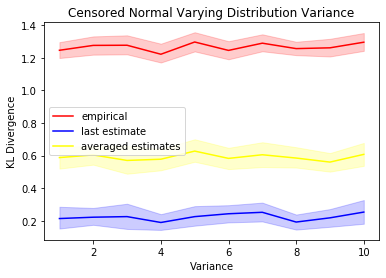

In [39]:
sns.lineplot(data=logs, x='var', y='kl_div_emp', color='red', label='empirical')
sns.lineplot(data=logs, x='var', y='kl_div_censored', color='blue', label='last estimate')
ax = sns.lineplot(data=logs, x='var', y='kl_div_censored_avg', color='yellow', label='averaged estimates')
ax.set_title('Censored Normal Varying Distribution Variance')
ax.set_xlabel('Variance')
ax.set_ylabel('KL Divergence')
ax.legend()

In [51]:
emp_dist = MultivariateNormal(ch.zeros(1), ch.ones(1, 1))

In [54]:
gt_dist = MultivariateNormal(ch.zeros(1) + .5, ch.ones(1, 1))

In [55]:
kl_divergence(emp_dist, gt_dist)

tensor(0.1250)

In [62]:
censored.scale

tensor([[0.5863]])